# Notes - Features 6

In [1]:
import duckdb
import os
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

In [2]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [3]:
df = con.execute(
    """
    SELECT
        year,
        -- (training label) indicated if C or P, otherwise not
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            ELSE 0::UTINYINT
        END AS ca_down_c_or_p,
        -- maternal age in years
        mage_c,
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- father's age recode
        CASE
            WHEN fagerec11 >= 1 AND fagerec11 < 10 THEN fagerec11
            ELSE NULL
        END AS fagerec11,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            ELSE NULL
        END AS pwgt_r,
        -- delivery weight recode (in pounds)
        CASE
            WHEN dwgt_r >= 100 AND dwgt_r <= 400 THEN dwgt_r
            ELSE NULL
        END AS dwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            ELSE NULL
        END AS wtgain,
        -- weight gain recode
        CASE
            WHEN wtgain_rec >= 1 AND wtgain_rec <= 5 THEN wtgain_rec
            ELSE NULL
        END AS wtgain_rec,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- fetal presentation at delivery (TODO: remove cast when import fixed)
        CASE
            WHEN CAST(me_pres as UTINYINT) >= 1 AND CAST(me_pres as UTINYINT)  <= 3 THEN CAST(me_pres as UTINYINT)
            ELSE NULL
        END AS me_pres,
        -- final route and method of delivery (TODO: remove cast when import fixed)
        CASE
            WHEN CAST(me_route as UTINYINT) >= 1 AND CAST(me_route as UTINYINT)  <= 3 THEN CAST(me_route as UTINYINT)
            ELSE NULL
        END AS me_route,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- attendant at birth
        CASE
            WHEN attendant >= 1 AND attendant <= 5 THEN attendant
            ELSE NULL
        END AS attendant,
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- birth weight (grams)
        CASE
            WHEN dbwt >= 227 AND dbwt <= 8165 THEN dbwt
            ELSE NULL
        END AS dbwt,
        -- birth weight recode 12
        CASE
            WHEN bwtr12 >= 1 AND bwtr12 <= 11 THEN bwtr12
            ELSE NULL
        END AS bwtr12,
        -- birth weight recode 4
        CASE
            WHEN bwtr4 >= 1 AND bwtr4 <= 3 THEN bwtr4
            ELSE NULL
        END AS bwtr4,
        -- assisted ventilation (immediately)
        CASE
            WHEN ab_aven1 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven1 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven1,
        -- assisted ventilation > 6 hrs
        CASE
            WHEN ab_aven6 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven6 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven6,
        -- admitted to nicu
        CASE
            WHEN ab_nicu = 'Y' THEN 1::UTINYINT
            WHEN ab_nicu = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_nicu,
        -- surfactant
        CASE
            WHEN ab_surf = 'Y' THEN 1::UTINYINT
            WHEN ab_surf = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_surf,
        -- antibiotics for newborn
        CASE
            WHEN ab_anti = 'Y' THEN 1::UTINYINT
            WHEN ab_anti = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_anti,
        -- seizures
        CASE
            WHEN ab_seiz = 'Y' THEN 1::UTINYINT
            WHEN ab_seiz = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_seiz,
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            ELSE NULL
        END
        AS bmi,
        -- maternal bmi recode
        CASE
            WHEN bmi_r >= 1 AND bmi_r <= 6 THEN bmi_r
            ELSE NULL
        END
        AS bmi_r,
        -- maternal education
        CASE
            WHEN  meduc < 9 THEN meduc
            ELSE NULL
        END AS meduc,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- maternal race
        CASE
            WHEN  mrace6 < 7 THEN mrace6
            ELSE NULL
        END AS mrace6,
        -- paternal race
        CASE
            WHEN  frace6 < 7 THEN frace6
            ELSE NULL
        END AS frace6,
        -- maternal hispanic origin
        CASE
            WHEN  mhisp_r < 6 THEN mhisp_r
            ELSE NULL
        END AS mhisp_r,
        -- paternal hispanic origin
        CASE
            WHEN  fhisp_r < 6 THEN fhisp_r
            ELSE NULL
        END AS fhisp_r,
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= 2009
    ORDER BY
        year, dob_mm
    """
).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  ca_down_c_or_p  mage_c  fagecomb  fagerec11  pwgt_r  dwgt_r  \
0         2009               0      31        31          5      98     125   
1         2009               0      33        36          6     160     190   
2         2009               0      31        30          5     119     145   
3         2009               0      23        23          3     130     157   
4         2009               0      25        25          4     140     165   
...        ...             ...     ...       ...        ...     ...     ...   
61583852  2024               0      37      <NA>       <NA>     130     169   
61583853  2024               0      27        28          4     180     215   
61583854  2024               0      34      <NA>       <NA>     140     138   
61583855  2024               0      27        26          4     200     282   
61583856  2024               0      38        45          8     130     157   

          wtgain  wtgain_rec  rf_ppterm  ...        bmi  bmi_r  meduc  feduc  \
0             27           3          0  ...  19.100000      2      1      1   
1             30           3          0  ...  25.799999      3      1      1   
2             26           3          0  ...  21.100000      2      1      1   
3             27           3          0  ...  23.000000      2      1      1   
4             25           3          0  ...  26.400000      3      1      1   
...          ...         ...        ...  ...        ...    ...    ...    ...   
61583852      39           4          0  ...  20.400000      2      2   <NA>   
61583853      35           4          1  ...  28.200001      3      4      5   
61583854       0           1          0  ...  26.400000      3      2   <NA>   
61583855      82           5          0  ...  29.500000      3      6      3   
61583856      27           3          0  ...  19.200001      2      6      6   

          mrace6  frace6  mhisp_r  fhisp_r  pay_rec  wic  
0           <NA>    <NA>     <NA>     <NA>        3    0  
1           <NA>    <NA>     <NA>     <NA>        2    0  
2           <NA>    <NA>     <NA>     <NA>     <NA>    0  
3           <NA>    <NA>     <NA>     <NA>     <NA>    0  
4           <NA>    <NA>     <NA>     <NA>        3    0  
...          ...     ...      ...      ...      ...  ...  
61583852       1    <NA>        0     <NA>        1    0  
61583853       1       1        0        5        1    1  
61583854       1    <NA>        0     <NA>        1    1  
61583855       1       1        0        0        3    0  
61583856       1       1        0        0        3    0  

[61583857 rows x 43 columns]

In [4]:
df.dtypes

year               uint16
ca_down_c_or_p      uint8
mage_c              uint8
fagecomb            UInt8
fagerec11           UInt8
pwgt_r             UInt16
dwgt_r             UInt16
wtgain              UInt8
wtgain_rec          UInt8
rf_ppterm           UInt8
rf_fedrg            UInt8
rf_artec            UInt8
no_risks            UInt8
ld_indl             UInt8
me_pres             UInt8
me_route            UInt8
dmeth_rec           UInt8
attendant           UInt8
sex                 uint8
dbwt               UInt16
bwtr12              UInt8
bwtr4               UInt8
ab_aven1            UInt8
ab_aven6            UInt8
ab_nicu             UInt8
ab_surf             UInt8
ab_anti             UInt8
ab_seiz             UInt8
ca_disor            UInt8
ca_cchd             UInt8
ca_cdh              UInt8
ca_omph             UInt8
ca_gast             UInt8
bmi               float32
bmi_r              UInt16
meduc               UInt8
feduc               UInt8
mrace6              UInt8
frace6      

#### Missing values

In [5]:
df.isna().mean().sort_values(ascending=False)

attendant         1.000000
me_route          1.000000
rf_artec          0.984137
rf_fedrg          0.984137
mrace6            0.581573
frace6            0.451334
fhisp_r           0.411608
mhisp_r           0.331019
no_risks          0.328138
feduc             0.196215
fagecomb          0.174320
fagerec11         0.124189
bmi_r             0.091683
bmi               0.091598
pwgt_r            0.087172
dwgt_r            0.082160
wic               0.077582
meduc             0.075530
me_pres           0.074035
pay_rec           0.071831
ca_disor          0.065561
ca_cdh            0.065561
ca_omph           0.065561
ca_gast           0.065561
ca_cchd           0.065561
ab_aven1          0.064720
ab_surf           0.064720
ab_aven6          0.064720
ab_seiz           0.064720
ab_nicu           0.064720
ab_anti           0.064720
rf_ppterm         0.064288
ld_indl           0.063653
wtgain_rec        0.038353
wtgain            0.038353
dmeth_rec         0.001184
dbwt              0.000942
b

In [6]:
df.columns

Index(['year', 'ca_down_c_or_p', 'mage_c', 'fagecomb', 'fagerec11', 'pwgt_r',
       'dwgt_r', 'wtgain', 'wtgain_rec', 'rf_ppterm', 'rf_fedrg', 'rf_artec',
       'no_risks', 'ld_indl', 'me_pres', 'me_route', 'dmeth_rec', 'attendant',
       'sex', 'dbwt', 'bwtr12', 'bwtr4', 'ab_aven1', 'ab_aven6', 'ab_nicu',
       'ab_surf', 'ab_anti', 'ab_seiz', 'ca_disor', 'ca_cchd', 'ca_cdh',
       'ca_omph', 'ca_gast', 'bmi', 'bmi_r', 'meduc', 'feduc', 'mrace6',
       'frace6', 'mhisp_r', 'fhisp_r', 'pay_rec', 'wic'],
      dtype='object')

In [7]:
features = [
    "year", "mage_c", "fagecomb", "pwgt_r",
    "dwgt_r", "wtgain", "rf_ppterm", "dbwt",
    "ab_aven1", "ab_aven6", "ab_nicu", "ab_surf", "ab_anti", "ab_seiz",
    "no_risks", "ld_indl", "me_pres", "dmeth_rec",
    "sex", "ca_disor", "ca_cchd", "ca_cdh", "ca_omph",
    "bmi", "meduc", "feduc", "mrace6", "frace6",
    "mhisp_r", "fhisp_r", "pay_rec", "wic"
]

X = df[features]
y = df["ca_down_c_or_p"]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

In [9]:
from lightgbm import early_stopping, log_evaluation

categorical = [
    "rf_ppterm", "ab_aven1", "ab_aven6", "ab_nicu", "ab_surf", "ab_anti", "ab_seiz",
    "no_risks", "ld_indl", "me_pres", "dmeth_rec",
    "ca_disor", "ca_cchd", "ca_cdh", "ca_omph",
    "meduc", "feduc", "mrace6", "frace6",
    "mhisp_r", "fhisp_r", "pay_rec", "wic"
]

numeric = [
    "year", "dbwt", "mage_c", "fagecomb", "pwgt_r", "dwgt_r", "wtgain", "bmi"
]

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False
)

neg_count = (y_train == 0).count()
pos_count = (y_train == 1).count()
scale_pos_weight = np.sqrt(neg_count / pos_count)

params = {
    # Core
    "objective": "binary",
    "boosting_type": "gbdt",
    "data_sample_strategy": "goss",
    "top_rate": 0.1,
    "other_rate": 0.05,
    "learning_rate": 0.05,

    # tree complexity
    "num_leaves": 512,
    "max_depth": 10,
    "min_data_in_leaf": 4000,
    "max_bin": 127,

    "feature_fraction": 0.7,

    # Weight regularisation
    "lambda_l1": 0.0,
    "lambda_l2": 5.0,

    # Splitting threshold
    "min_gain_to_split": 0.0,

    # Imbalance handling
    "scale_pos_weight": scale_pos_weight,

    # categorical one-hot encoding
    "force_col_wise": True,
    "max_cat_threshold": 64,
    "max_cat_to_onehot": 32,

    # Metrics and infrastructure
    "metric": ["average_precision", "auc"],
    "num_threads": 22, #14,
    "verbose": 1,
}


gbm = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=5)
    ]
)


[LightGBM] [Info] Number of positive: 23927, number of negative: 49243158
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 49267085, number of used features: 32
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000486 -> initscore=-7.629518
[LightGBM] [Info] Start training from score -7.629518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's average_precision: 0.0231693	train's auc: 0.884129	valid's average_precision: 0.0221237	valid's auc: 0.880986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

To improve on:

- Validation AUC: 0.8879
- Validation AUPRC: 0.0311

In [10]:
from datetime import datetime
gbm.save_model(f"./output/features_model_{datetime.now().strftime("%Y%m%d%H%M")}.txt", num_iteration=gbm.best_iteration)

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_valid_pred_proba = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

auc = roc_auc_score(y_valid, y_valid_pred_proba)
aupr = average_precision_score(y_valid, y_valid_pred_proba)

print(f"Validation AUC:  {auc:.4f}")
print(f"Validation AUPRC:{aupr:.4f}")


Validation AUC:  0.8897
Validation AUPRC:0.0289


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_age = LogisticRegression(max_iter=1000)
lr_age.fit(X_train[["mage_c"]], y_train)
p_age = lr_age.predict_proba(X_valid[["mage_c"]])[:, 1]
print("AUC (age only):", roc_auc_score(y_valid, p_age))


AUC (age only): 0.7012240937366975


In [13]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(f"./output/importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

df_imp_gain

feature  importance_gain
10    ab_nicu    252459.063836
1      mage_c    198053.157912
20    ca_cchd    140868.789398
7        dbwt     92629.790477
19   ca_disor     91783.207982
8    ab_aven1     29135.305393
2    fagecomb     24448.155255
5      wtgain     19392.447191
4      dwgt_r     14117.793565
23        bmi     13996.953353
3      pwgt_r     12385.254403
9    ab_aven6     12164.336316
12    ab_anti     11518.391333
24      meduc     10087.729185
27     frace6      8615.842586
0        year      8062.739395
17  dmeth_rec      6935.770352
25      feduc      6835.850520
21     ca_cdh      5831.712943
26     mrace6      5687.630474
30    pay_rec      5331.221539
16    me_pres      4890.327240
14   no_risks      4664.902235
22    ca_omph      3895.585251
15    ld_indl      3862.130157
28    mhisp_r      3680.626680
29    fhisp_r      2747.113357
18        sex      2425.118113
31        wic      1441.812285
11    ab_surf       970.885397
6   rf_ppterm       959.296960
13    ab_seiz       601.433243

In [14]:
pos_idx = y_valid[y_valid == 1].index
neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx]
y_eval = y_valid.loc[eval_idx]


In [15]:
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance

def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)

class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)

model_wrapped = LGBMWrapper(gbm)


In [16]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=5,       # small but OK given size
    n_jobs=4,          # adjust for your machine
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(f"./output/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
perm_importance

feature  importance_mean  importance_std
10    ab_nicu         0.188667        0.001593
1      mage_c         0.140002        0.001921
19   ca_disor         0.105790        0.001217
20    ca_cchd         0.054998        0.001482
7        dbwt         0.054671        0.001532
8    ab_aven1         0.012689        0.000388
5      wtgain         0.007007        0.000420
12    ab_anti         0.005901        0.000748
17  dmeth_rec         0.004729        0.000426
9    ab_aven6         0.004067        0.000211
15    ld_indl         0.003792        0.000448
16    me_pres         0.002920        0.000435
14   no_risks         0.002324        0.000403
0        year         0.002143        0.000426
3      pwgt_r         0.001987        0.000339
27     frace6         0.001937        0.000229
24      meduc         0.001784        0.000392
23        bmi         0.001687        0.000187
30    pay_rec         0.001638        0.000255
26     mrace6         0.001191        0.000384
18        sex         0.001069        0.000237
4      dwgt_r         0.000992        0.000407
2    fagecomb         0.000890        0.000302
22    ca_omph         0.000834        0.000224
28    mhisp_r         0.000793        0.000152
25      feduc         0.000716        0.000141
21     ca_cdh         0.000620        0.000210
29    fhisp_r         0.000462        0.000059
11    ab_surf         0.000348        0.000121
31        wic         0.000282        0.000030
6   rf_ppterm         0.000256        0.000125
13    ab_seiz         0.000067        0.000099

In [17]:
# e.g. take all positives from X_eval and match them 1:2 with negatives
pos_eval_idx = y_eval[y_eval == 1].index
neg_eval_idx = y_eval[y_eval == 0].index

n_pos_shap = min(5_000, len(pos_eval_idx))
n_neg_shap = min(2 * n_pos_shap, len(neg_eval_idx))  # 2:1 neg:pos

pos_shap = rng.choice(pos_eval_idx, size=n_pos_shap, replace=False)
neg_shap = rng.choice(neg_eval_idx, size=n_neg_shap, replace=False)

shap_idx = np.concatenate([pos_shap, neg_shap])
shap_idx = rng.permutation(shap_idx)

X_shap = X_eval.loc[shap_idx]
y_shap = y_eval.loc[shap_idx]


In [18]:
import shap

# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_shap)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values     # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(f"./output/shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

shap_importance


feature  mean_abs_shap
10    ab_nicu       0.699910
1      mage_c       0.572932
7        dbwt       0.376284
21     ca_cdh       0.129145
19   ca_disor       0.126035
8    ab_aven1       0.117019
20    ca_cchd       0.115006
5      wtgain       0.087464
3      pwgt_r       0.069201
27     frace6       0.065404
23        bmi       0.063735
22    ca_omph       0.056674
0        year       0.053917
2    fagecomb       0.050875
4      dwgt_r       0.047656
17  dmeth_rec       0.046897
16    me_pres       0.045723
26     mrace6       0.037689
12    ab_anti       0.037147
15    ld_indl       0.035223
9    ab_aven6       0.034565
24      meduc       0.033792
30    pay_rec       0.032000
14   no_risks       0.026856
25      feduc       0.026703
18        sex       0.017722
28    mhisp_r       0.013737
29    fhisp_r       0.011912
13    ab_seiz       0.011529
31        wic       0.009270
11    ab_surf       0.005583
6   rf_ppterm       0.004470

In [34]:
X_shap_fp

year  mage_c  fagecomb  pwgt_r  dwgt_r  wtgain  rf_ppterm    dbwt  \
12995215  2012.0    19.0       NaN     NaN     NaN    30.0        NaN  3231.0   
10312655  2011.0    44.0      48.0   140.0   158.0    18.0        0.0  2970.0   
37111127  2018.0    27.0      32.0   118.0   152.0    34.0        0.0  3230.0   
58090660  2024.0    37.0      39.0   125.0   184.0    59.0        1.0  3490.0   
44846314  2020.0    35.0      38.0   229.0   268.0    39.0        0.0  3182.0   
...          ...     ...       ...     ...     ...     ...        ...     ...   
26076887  2015.0    30.0      31.0   134.0   173.0    39.0        0.0  3277.0   
56370492  2023.0    23.0      24.0   175.0   177.0     2.0        0.0  3690.0   
30611284  2016.0    23.0      23.0   200.0   224.0    24.0        0.0  3328.0   
963901    2009.0    25.0      28.0   125.0   143.0    18.0        0.0  3084.0   
33096668  2017.0    29.0      30.0   141.0   176.0    35.0        0.0  3742.0   

          ab_aven1  ab_aven6  ...  ca_omph        bmi  meduc  feduc  mrace6  \
12995215       NaN       NaN  ...      NaN        NaN    NaN    NaN     NaN   
10312655       0.0       0.0  ...      0.0  25.600000    2.0    2.0     NaN   
37111127       0.0       0.0  ...      0.0  19.000000    3.0    4.0     1.0   
58090660       0.0       0.0  ...      0.0  23.600000    6.0    6.0     4.0   
44846314       0.0       0.0  ...      0.0  39.299999    4.0    5.0     1.0   
...            ...       ...  ...      ...        ...    ...    ...     ...   
26076887       0.0       0.0  ...      0.0  18.200001    6.0    6.0     NaN   
56370492       1.0       0.0  ...      0.0  27.400000    3.0    2.0     1.0   
30611284       0.0       0.0  ...      0.0  36.599998    1.0    3.0     NaN   
963901         0.0       0.0  ...      0.0  21.500000    5.0    2.0     NaN   
33096668       0.0       0.0  ...      0.0  21.400000    6.0    6.0     NaN   

          frace6  mhisp_r  fhisp_r  pay_rec  wic  
12995215     NaN      NaN      NaN      NaN  NaN  
10312655     NaN      NaN      NaN      1.0  1.0  
37111127     1.0      0.0      4.0      2.0  0.0  
58090660     NaN      0.0      4.0      2.0  0.0  
44846314     1.0      0.0      0.0      2.0  0.0  
...          ...      ...      ...      ...  ...  
26076887     1.0      0.0      0.0      2.0  1.0  
56370492     1.0      0.0      0.0      1.0  1.0  
30611284     2.0      5.0      0.0      1.0  1.0  
963901       NaN      NaN      NaN      1.0  1.0  
33096668     1.0      0.0      0.0      2.0  0.0  

[15000 rows x 32 columns]

In [55]:

def _to_float_array(a):
    """
    Convert an array that may contain pd.NA / None / strings to float,
    coercing non-numeric to NaN.
    """
    # Keep as object so pd.NA doesn't explode during np.asarray(..., dtype=float)
    a_obj = np.asarray(a, dtype=object)
    return pd.to_numeric(pd.Series(a_obj), errors="coerce").to_numpy(dtype=np.float64)

def plot_shap_dependence_scatter(feature_name: str, color_feature_name: str | None = None):
    x = _to_float_array(explanation[:, feature_name].data)
    c = _to_float_array(explanation[:, color_feature_name].data)

    sv = np.asarray(explanation[:, feature_name].values, dtype=np.float64)
    mask = np.isfinite(x) & np.isfinite(c) & np.isfinite(sv)

    exp_f = explanation[mask]
    shap.plots.scatter(exp_f[:, feature_name], color=exp_f[:, color_feature_name])

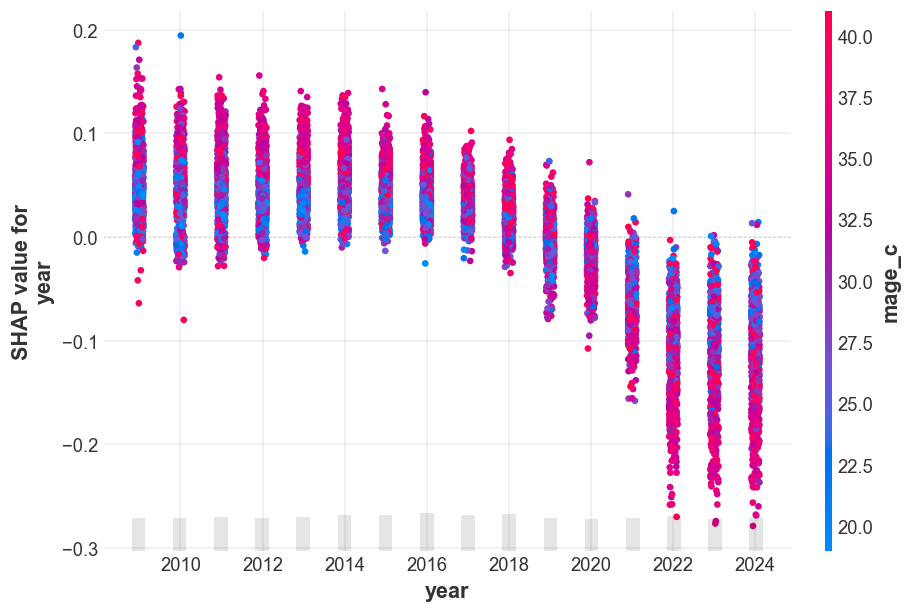

In [45]:
shap.plots.scatter(explanation[:,"year"], color=explanation[:,"mage_c"])

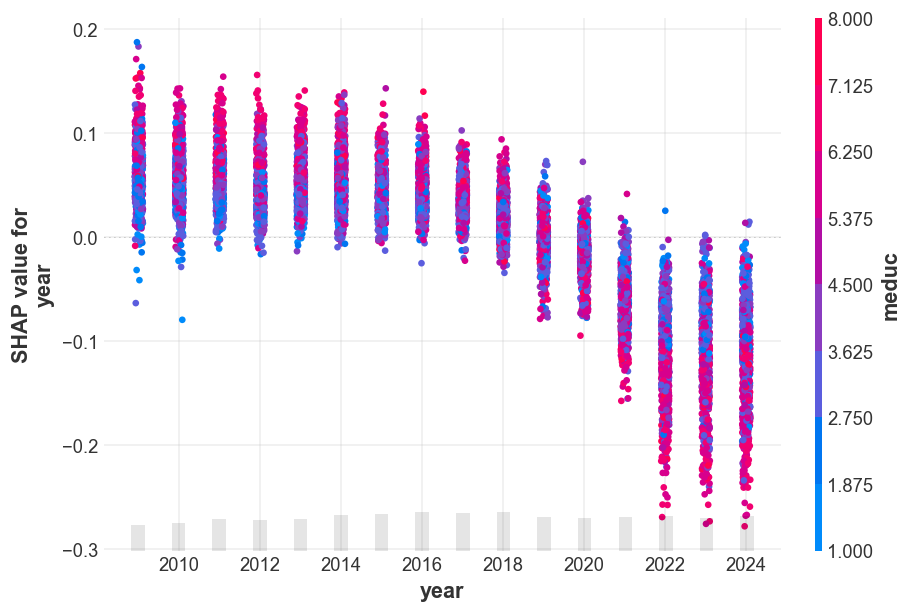

In [58]:
plot_shap_dependence_scatter("year", "meduc")

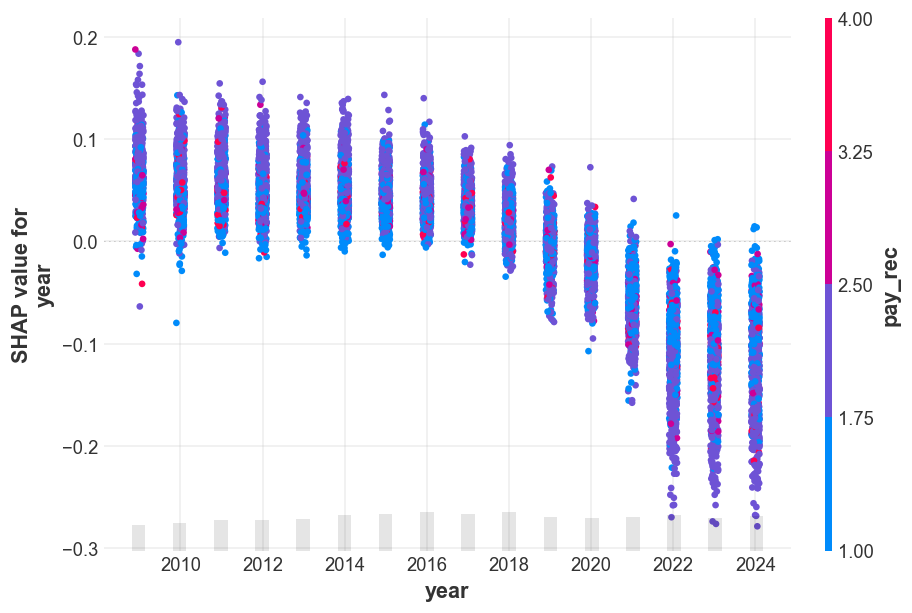

In [75]:
plot_shap_dependence_scatter("year", "pay_rec")

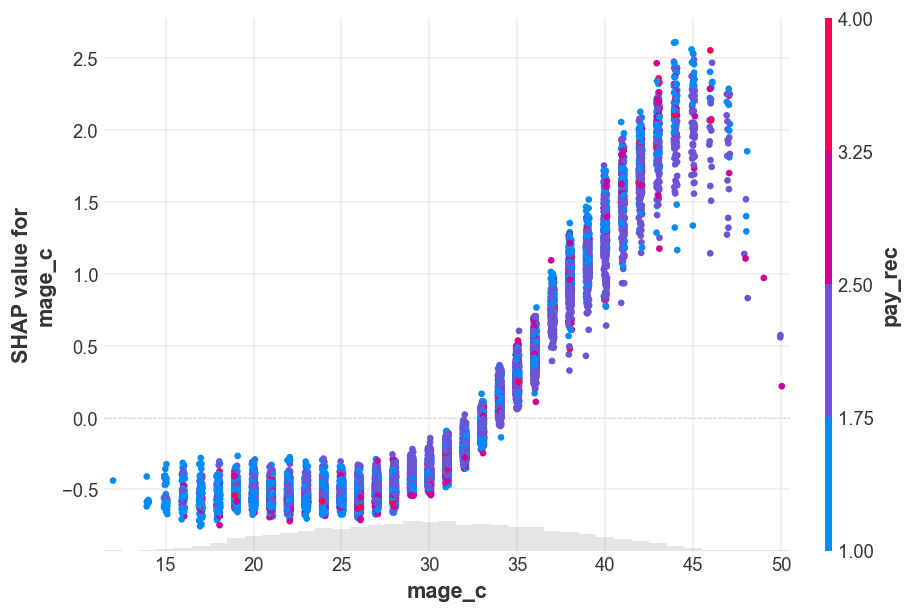

In [77]:
plot_shap_dependence_scatter("mage_c", "pay_rec")

In [78]:
df[["mage_c", "pay_rec"]].describe()

mage_c     pay_rec
count  6.158386e+07  57160229.0
mean   2.866925e+01    1.699689
std    5.935986e+00    0.736063
min    1.200000e+01         1.0
25%    2.400000e+01         1.0
50%    2.900000e+01         2.0
75%    3.300000e+01         2.0
max    5.000000e+01         4.0

C:\Users\FrankBuckley\AppData\Local\Temp\ipykernel_59664\3475898708.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  ct.index = pd.to_numeric(ct.index, errors="ignore")
C:\Users\FrankBuckley\AppData\Local\Temp\ipykernel_59664\3475898708.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


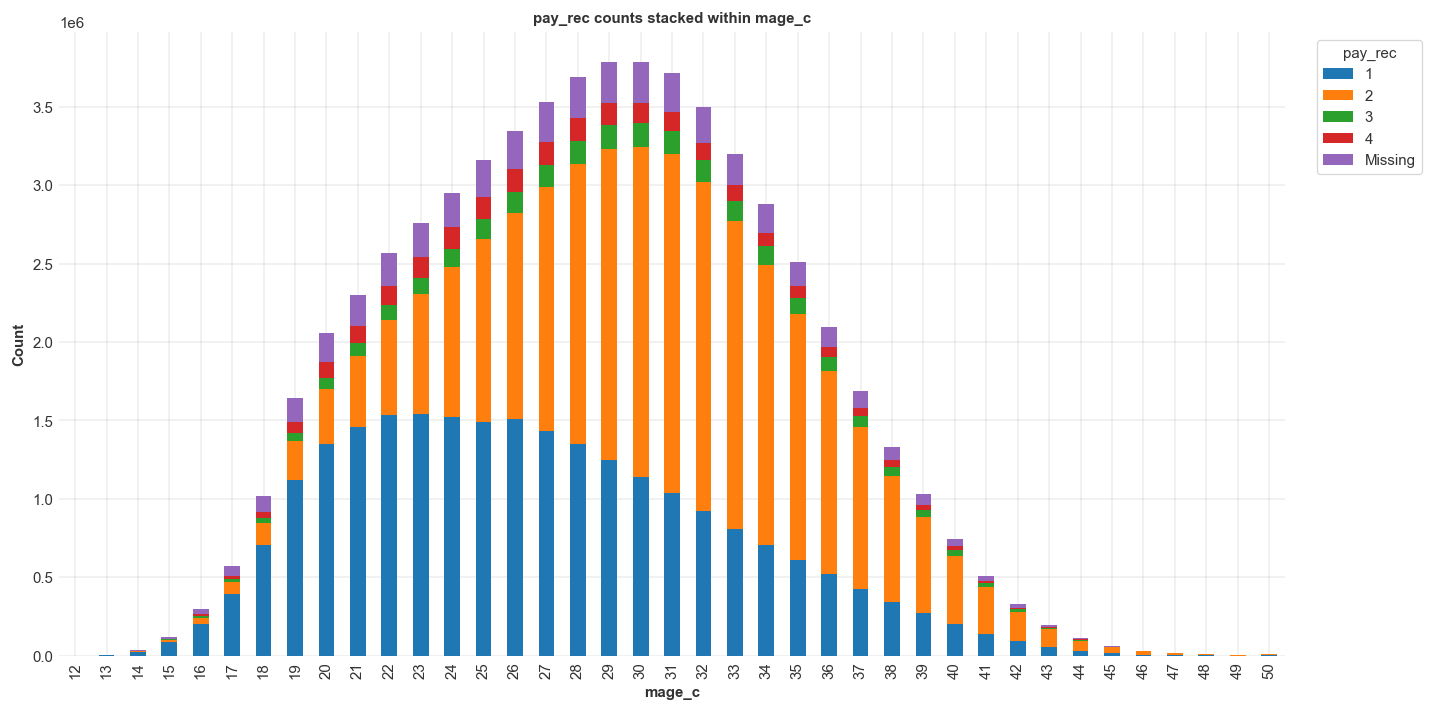

In [79]:

# (optional) keep NA as its own category instead of dropping it
mage = df["mage_c"].copy()
pay  = df["pay_rec"].copy()

# If you want NA to appear as a bar segment:
mage = mage.astype("object").where(mage.notna(), "Missing")
pay  = pay.astype("object").where(pay.notna(),  "Missing")

# counts: rows = mage_c, columns = pay_rec
ct = pd.crosstab(mage, pay)

# nicer ordering if mage_c is numeric-like
try:
    ct.index = pd.to_numeric(ct.index, errors="ignore")
    ct = ct.sort_index()
except Exception:
    pass

ax = ct.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_xlabel("mage_c")
ax.set_ylabel("Count")
ax.set_title("pay_rec counts stacked within mage_c")
ax.legend(title="pay_rec", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

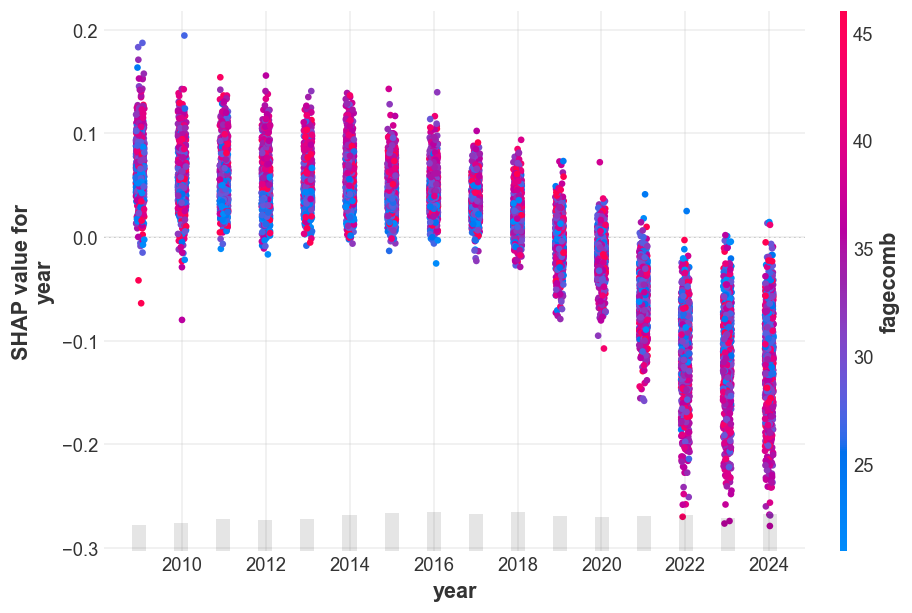

In [56]:
plot_shap_dependence_scatter("year", "fagecomb")

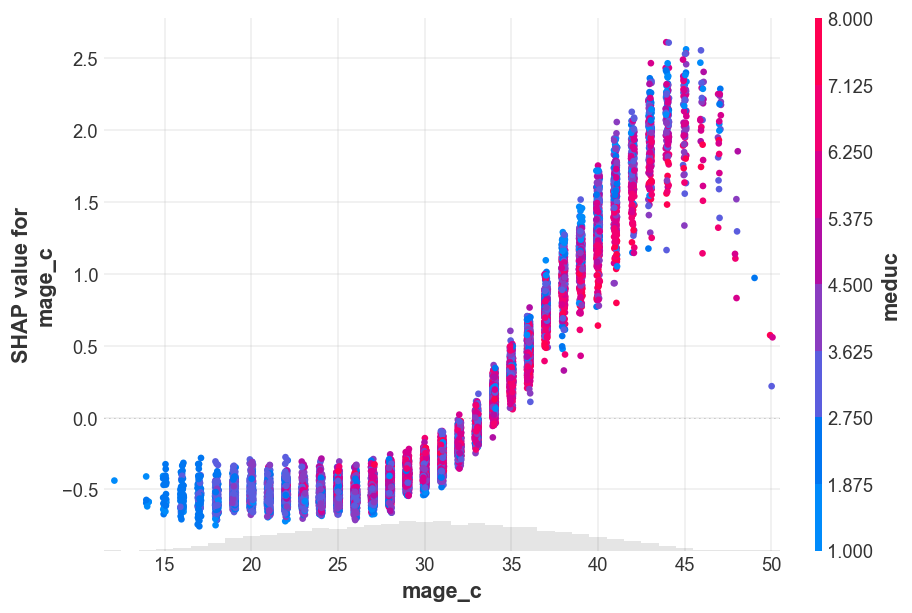

In [61]:
plot_shap_dependence_scatter("mage_c", "meduc")

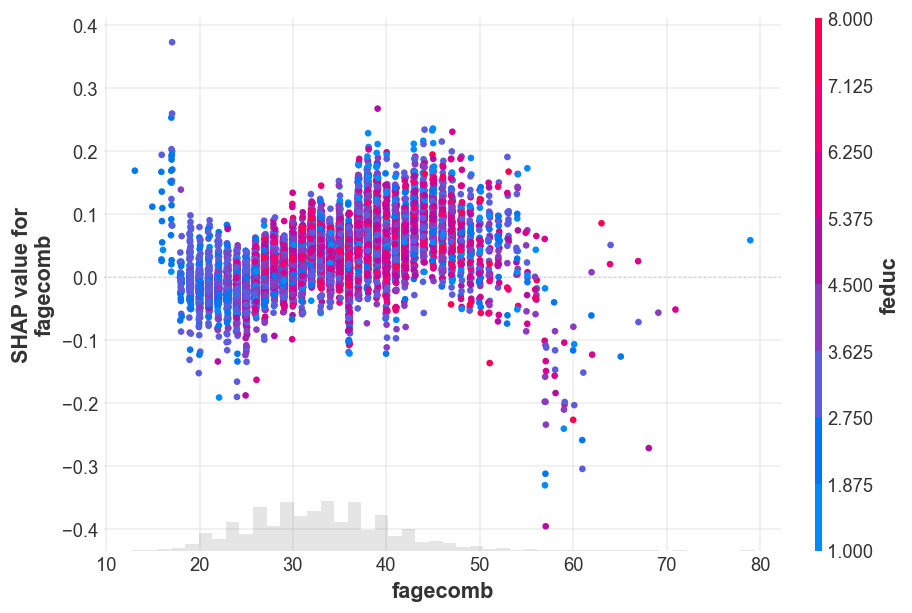

In [63]:
plot_shap_dependence_scatter("fagecomb", "feduc")

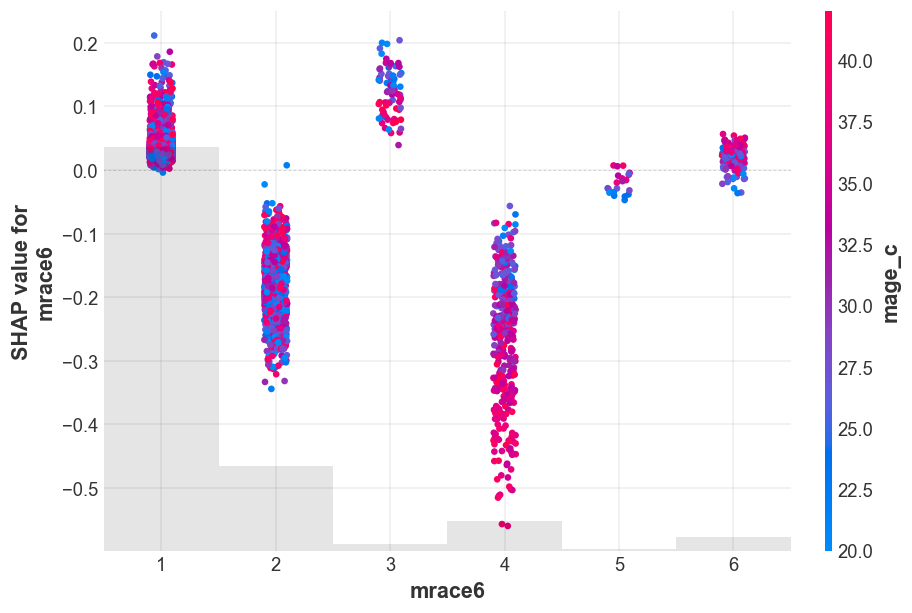

In [71]:
plot_shap_dependence_scatter("mrace6", "mage_c")

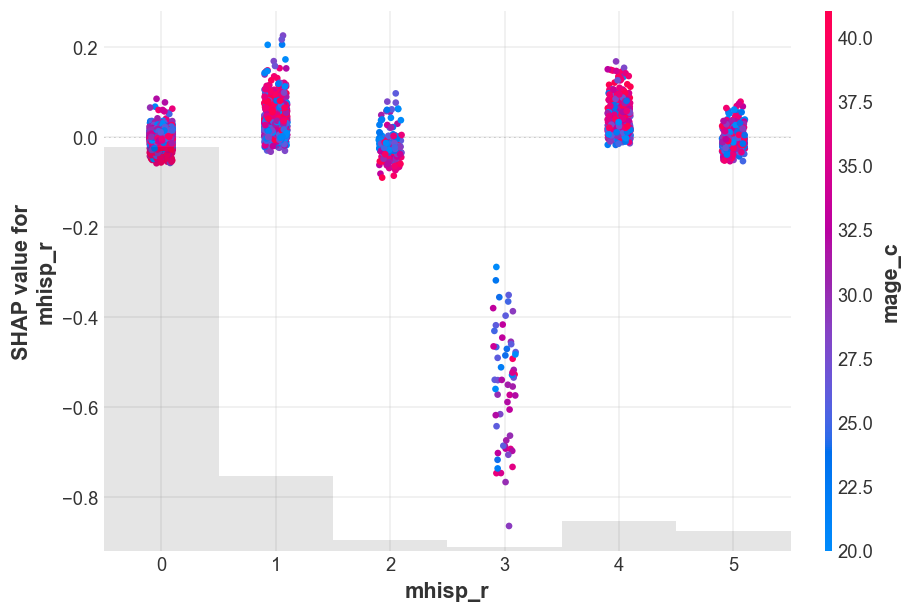

In [74]:
plot_shap_dependence_scatter("mhisp_r", "mage_c")

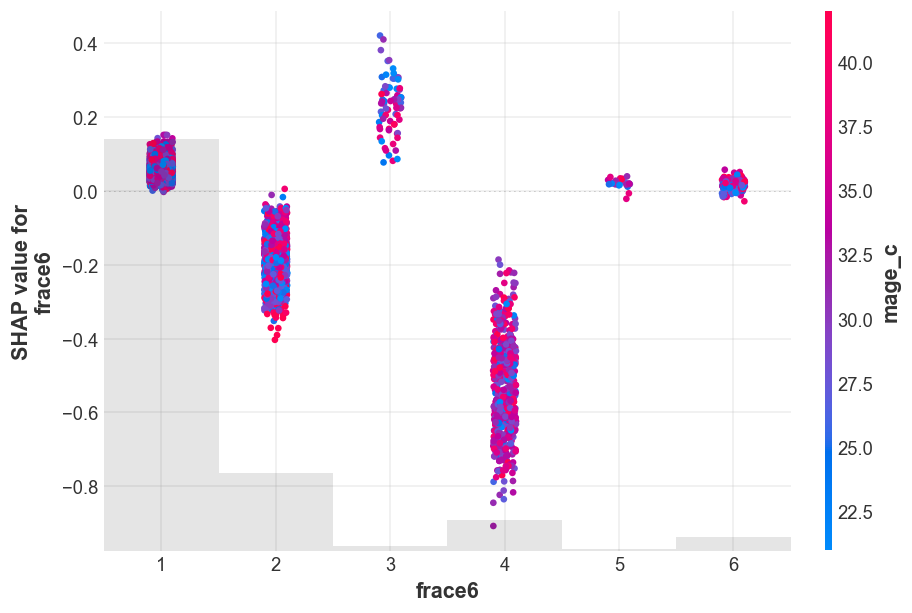

In [66]:
plot_shap_dependence_scatter("frace6", "mage_c")

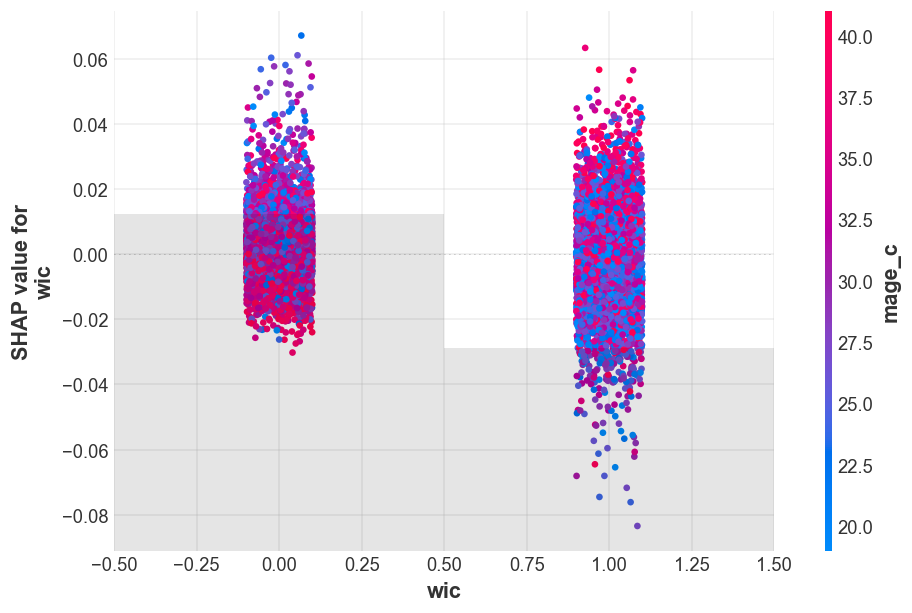

In [67]:
plot_shap_dependence_scatter("wic", "mage_c")

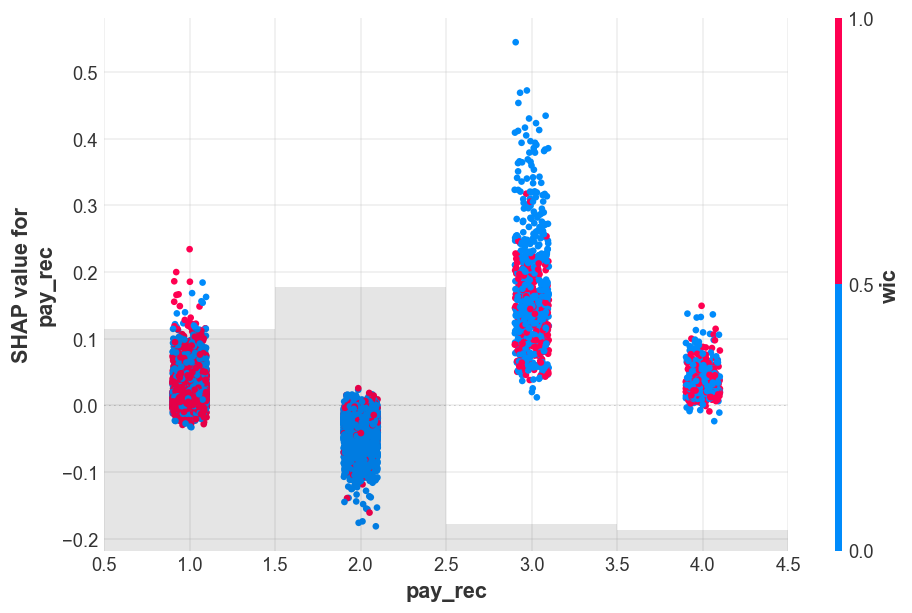

In [70]:
plot_shap_dependence_scatter("pay_rec", "wic")

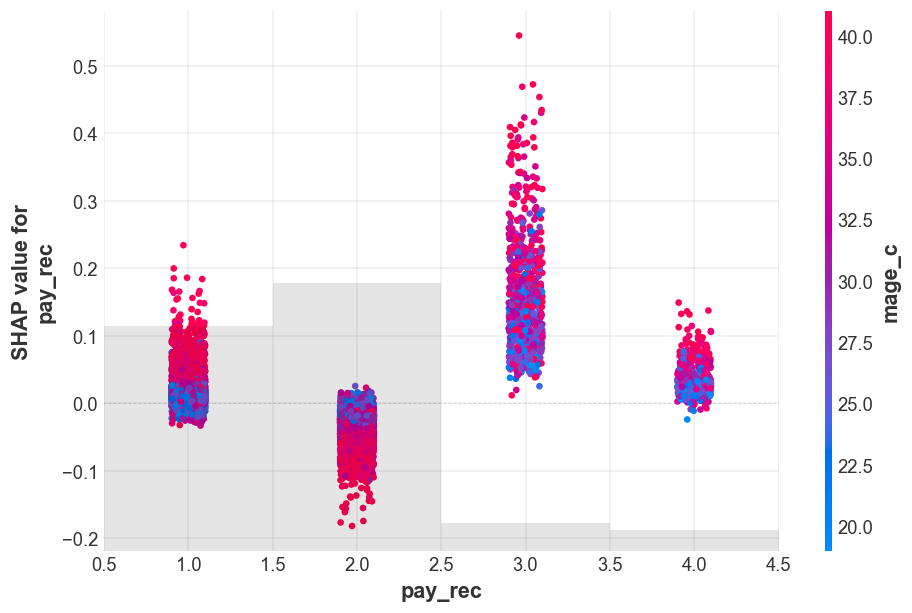

In [69]:
plot_shap_dependence_scatter("pay_rec", "mage_c")


Feature: year


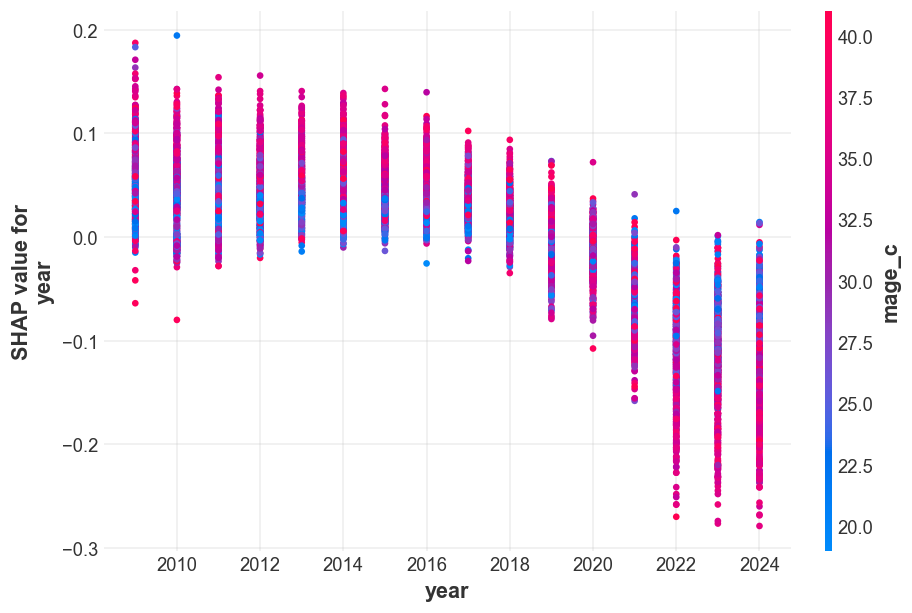


Feature: mage_c


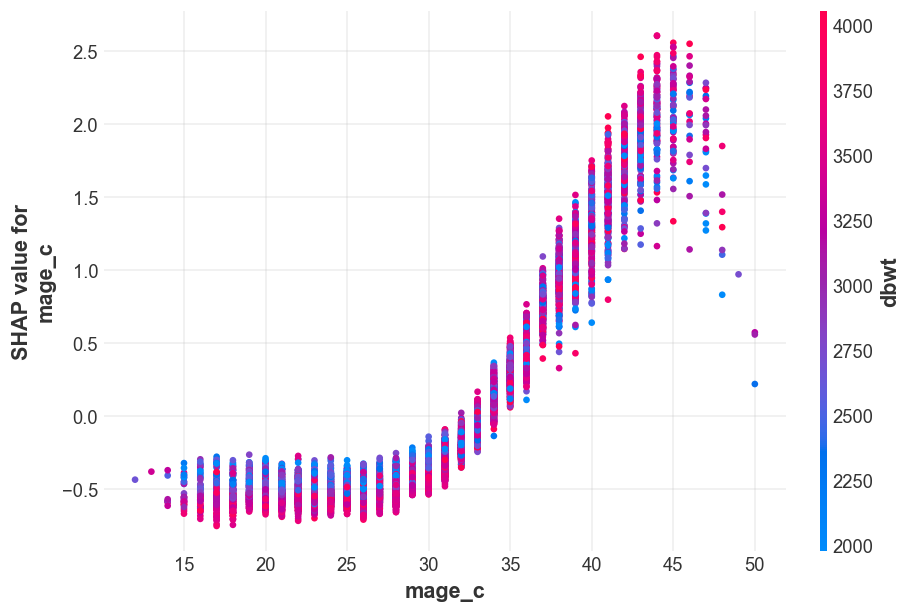


Feature: fagecomb


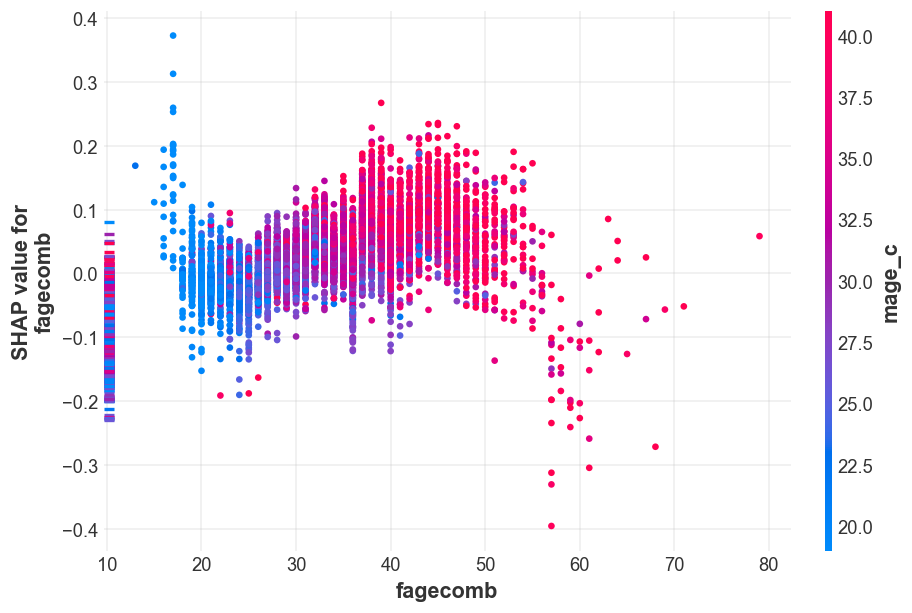


Feature: pwgt_r


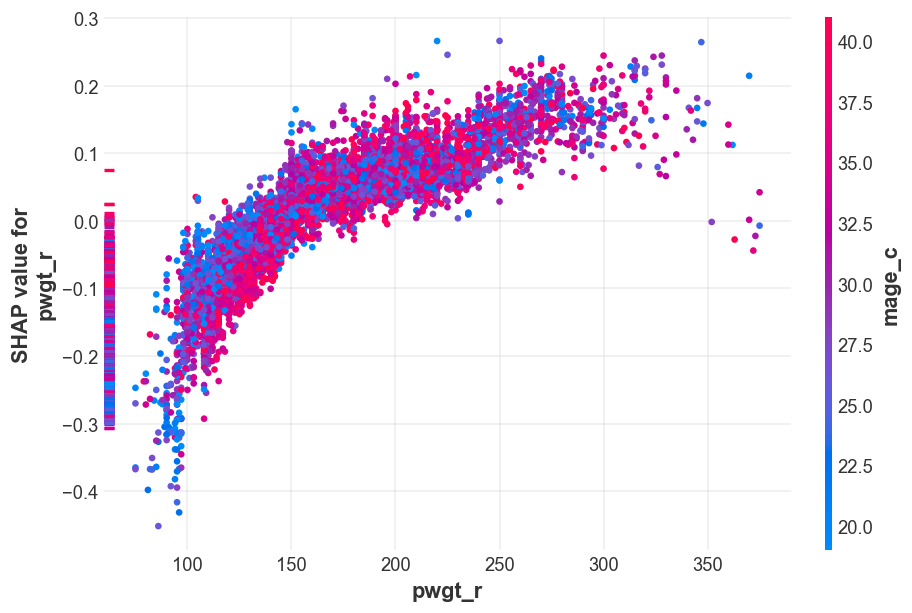


Feature: dwgt_r


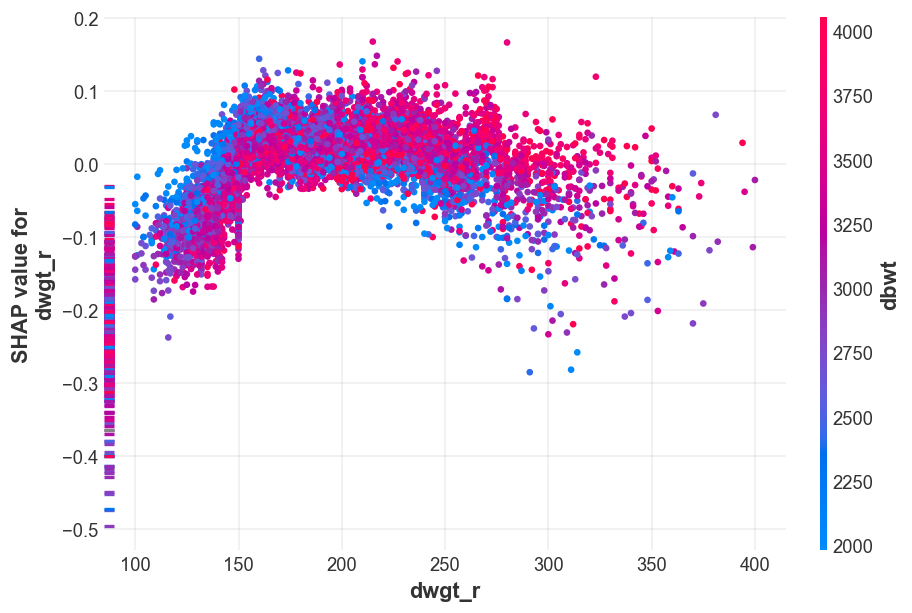


Feature: wtgain


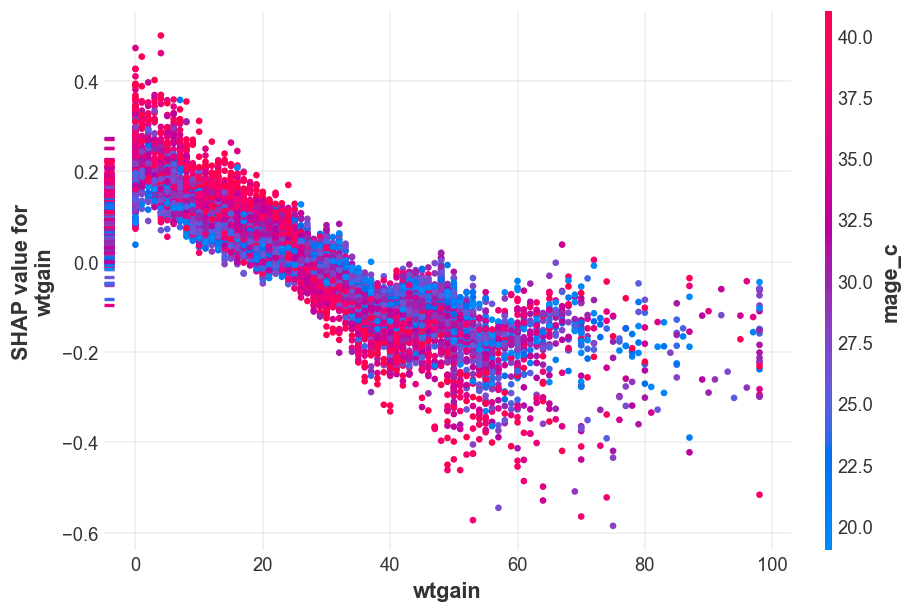


Feature: rf_ppterm


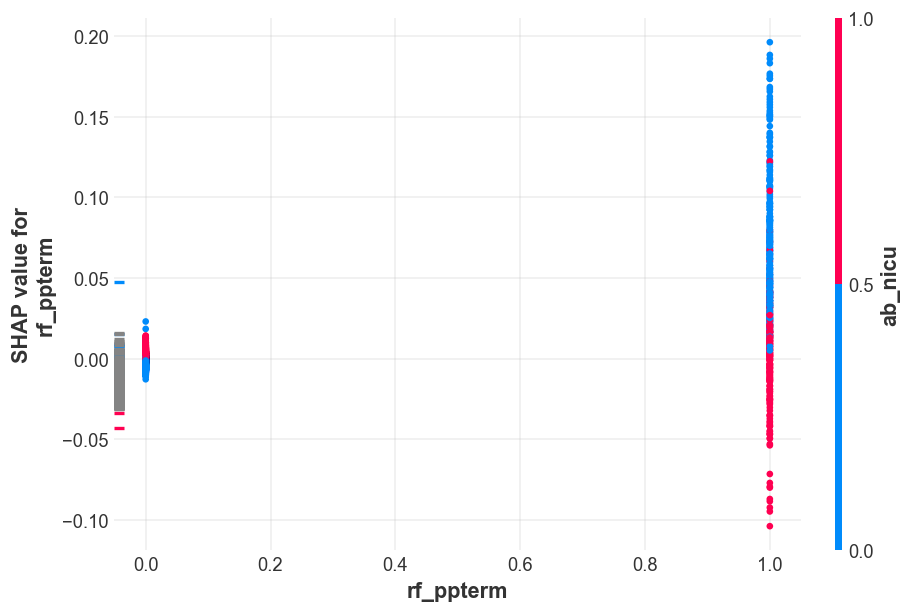


Feature: dbwt


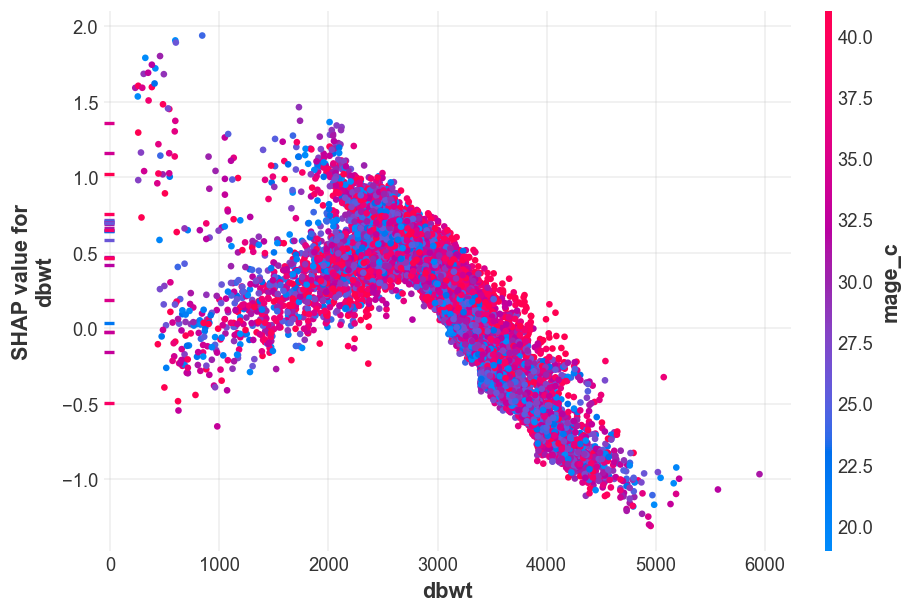


Feature: ab_aven1


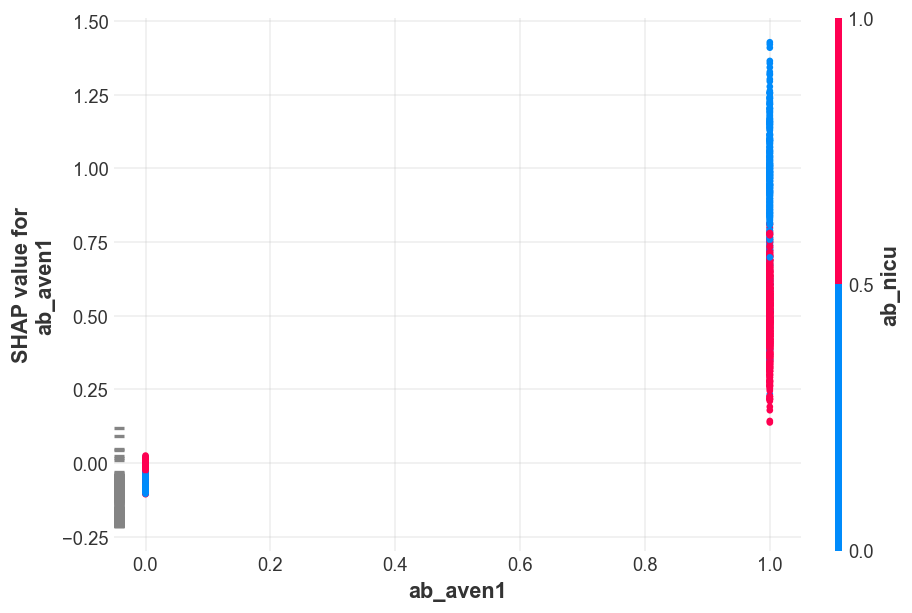


Feature: ab_aven6


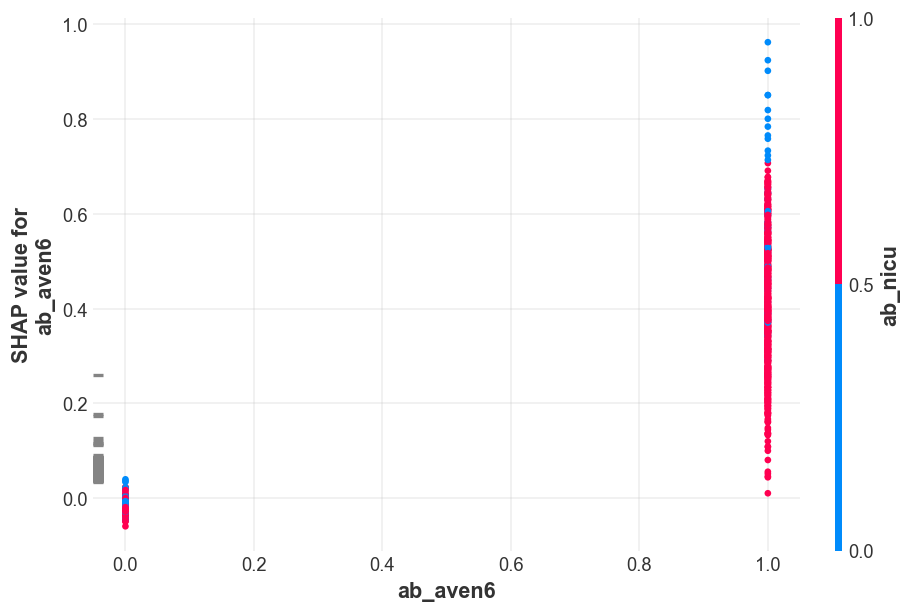


Feature: ab_nicu


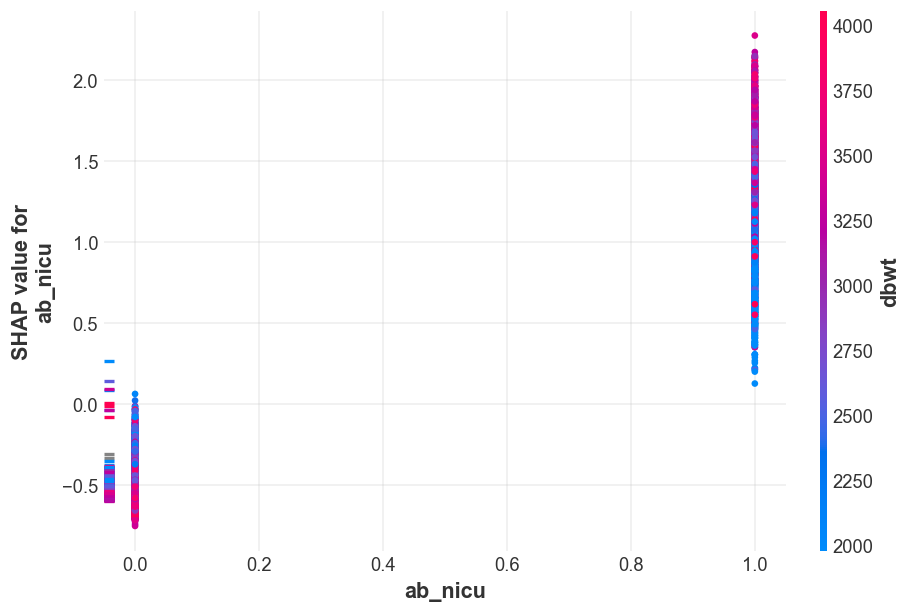


Feature: ab_surf


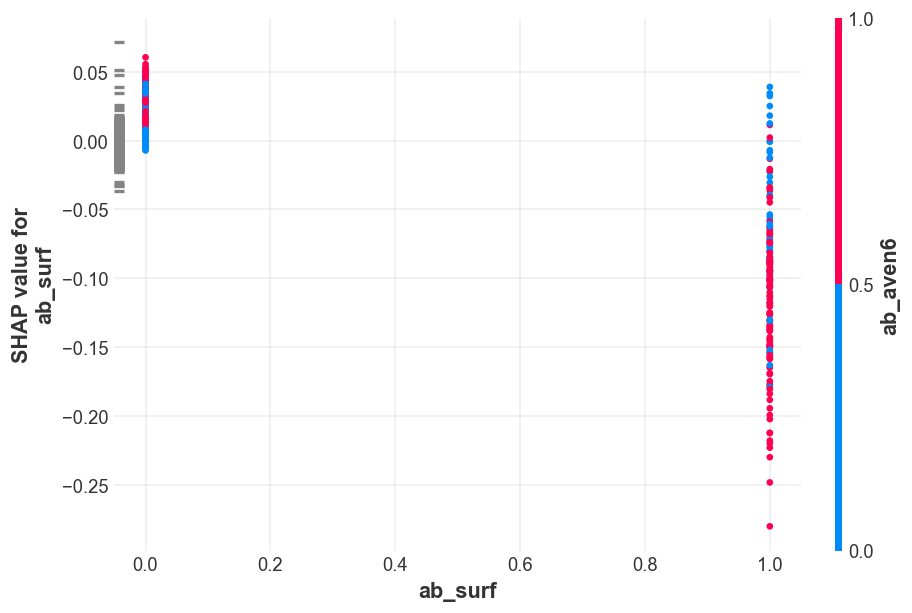


Feature: ab_anti


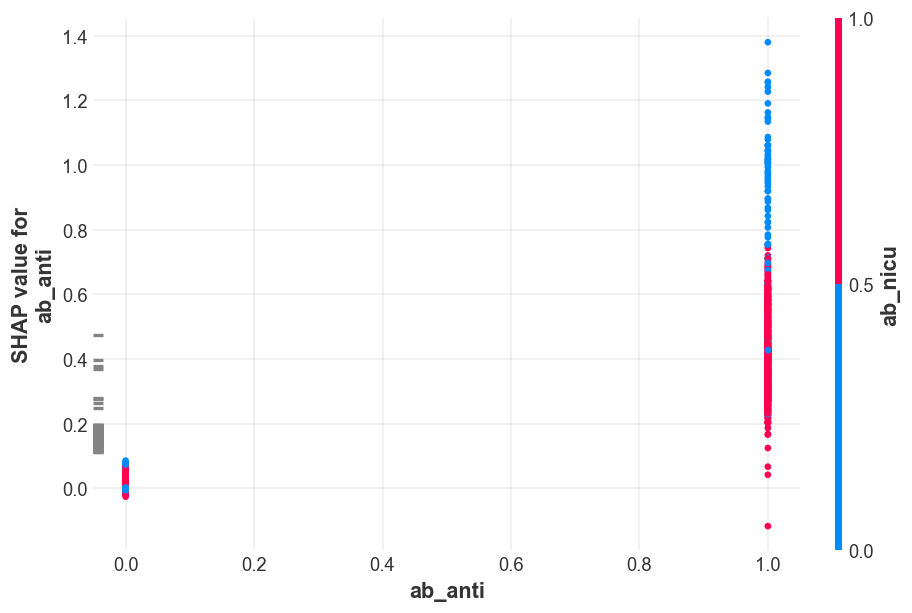


Feature: ab_seiz


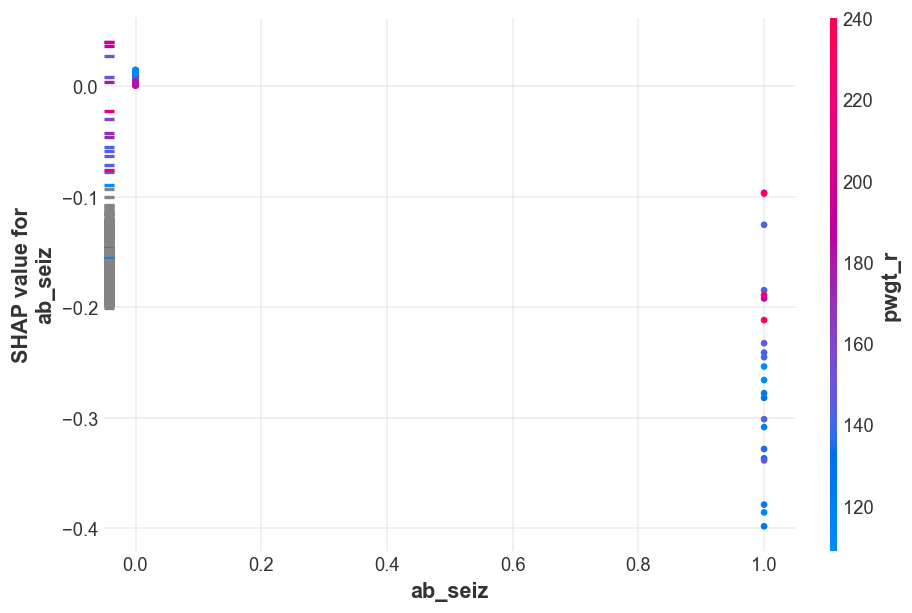


Feature: no_risks


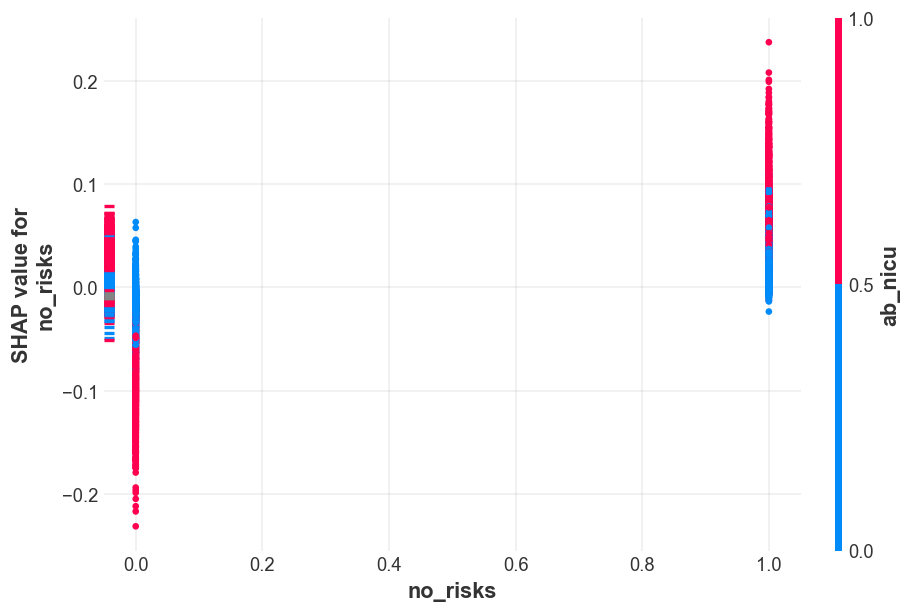


Feature: ld_indl


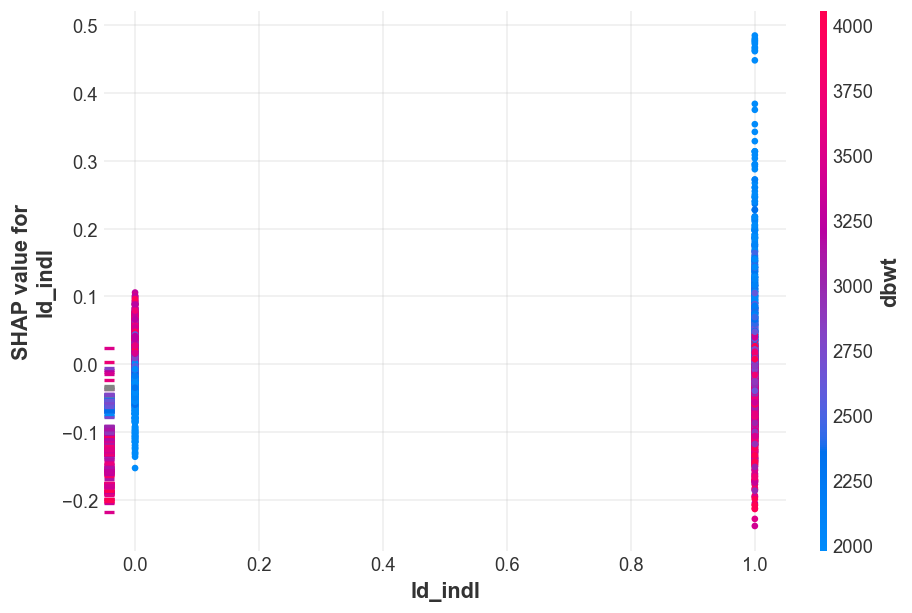


Feature: me_pres


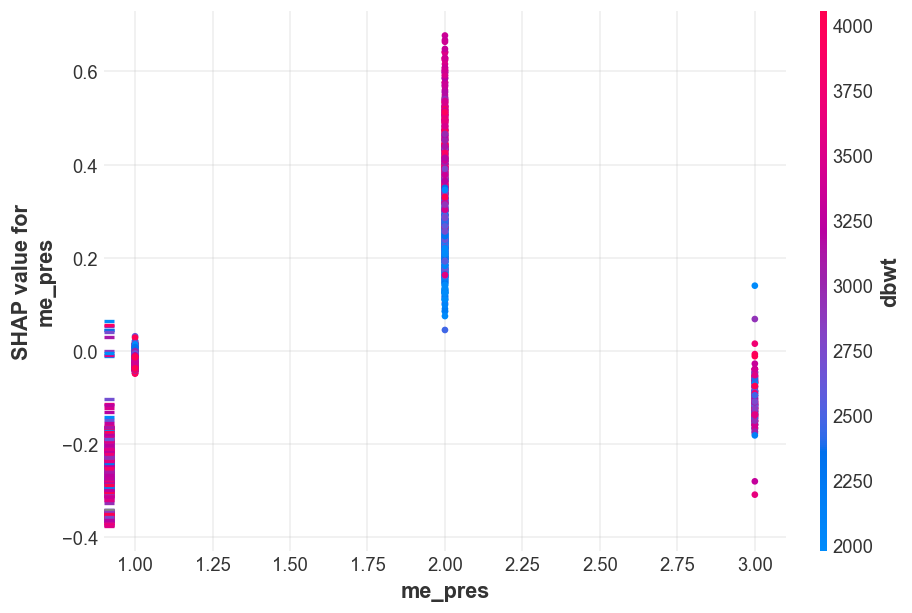


Feature: dmeth_rec


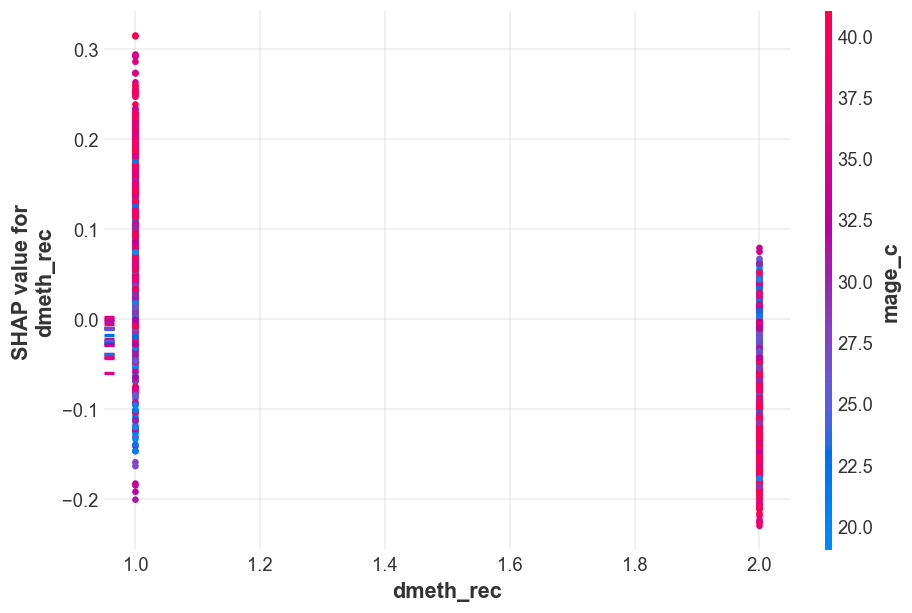


Feature: sex


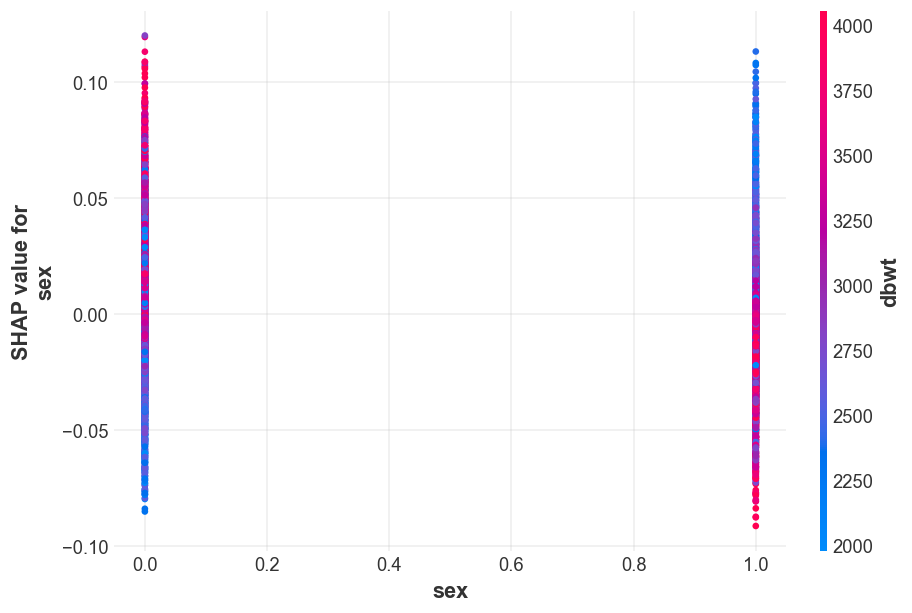


Feature: ca_disor


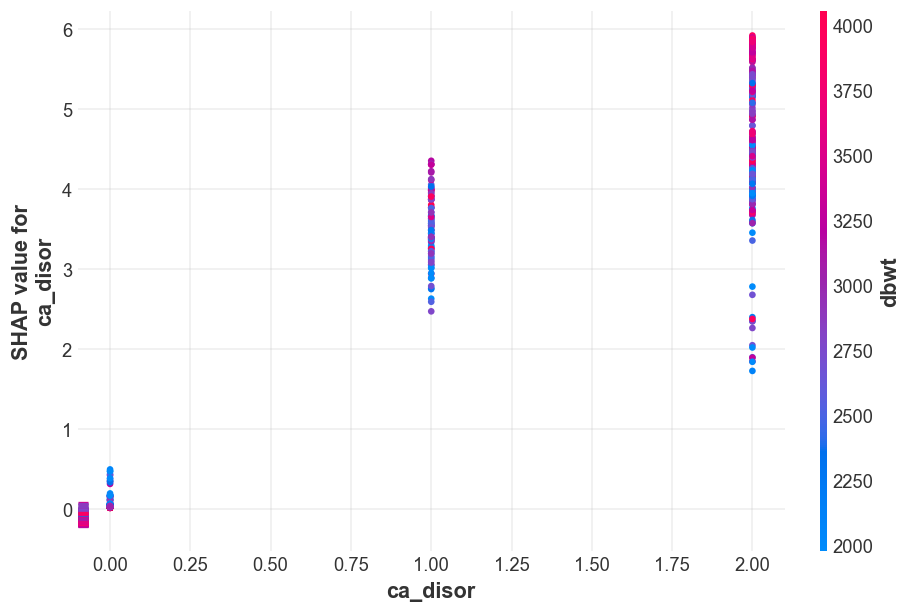


Feature: ca_cchd


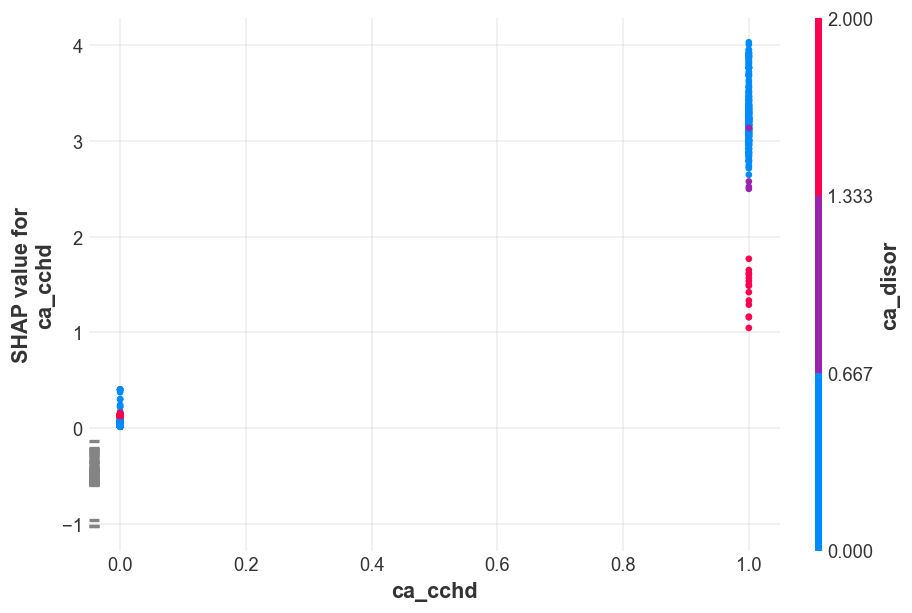


Feature: ca_cdh


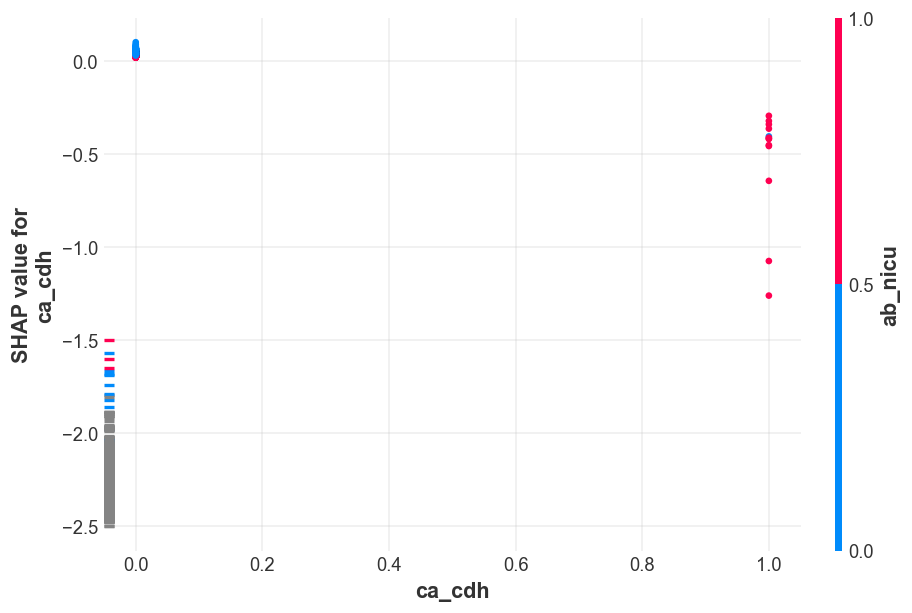


Feature: ca_omph


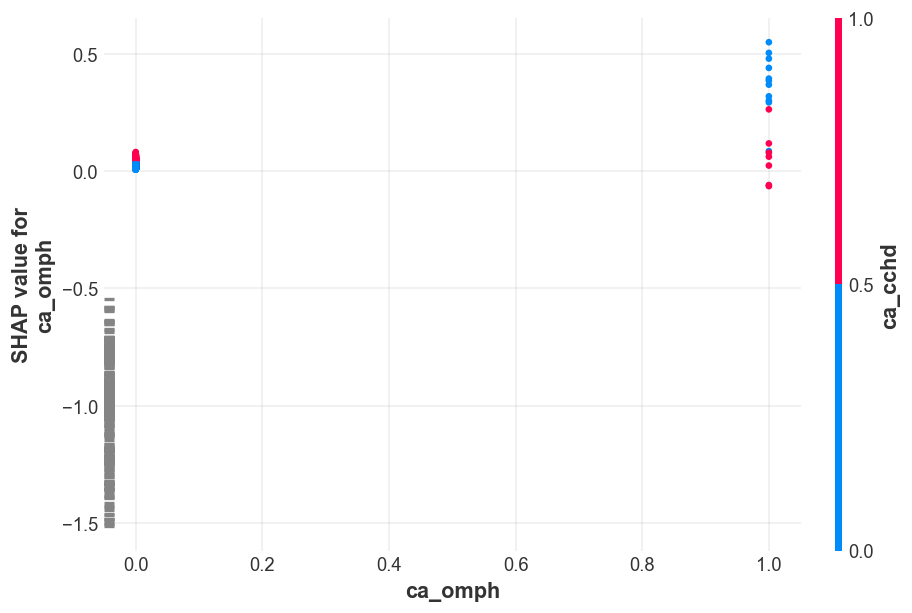


Feature: bmi


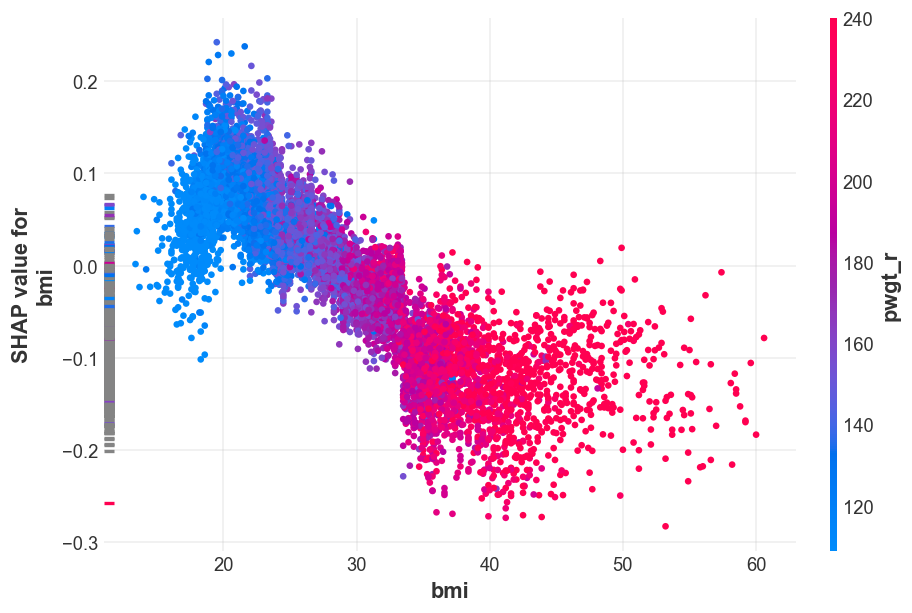


Feature: meduc


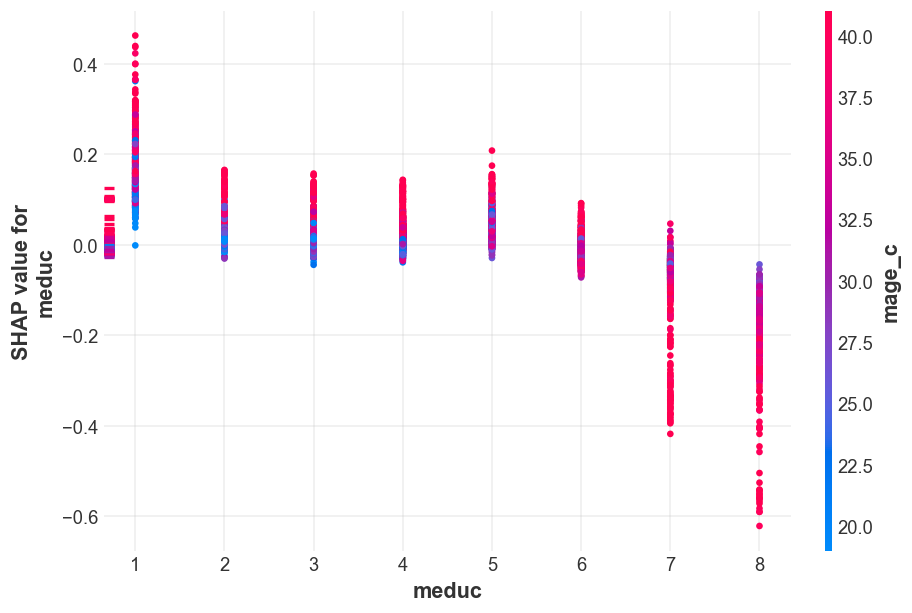


Feature: feduc


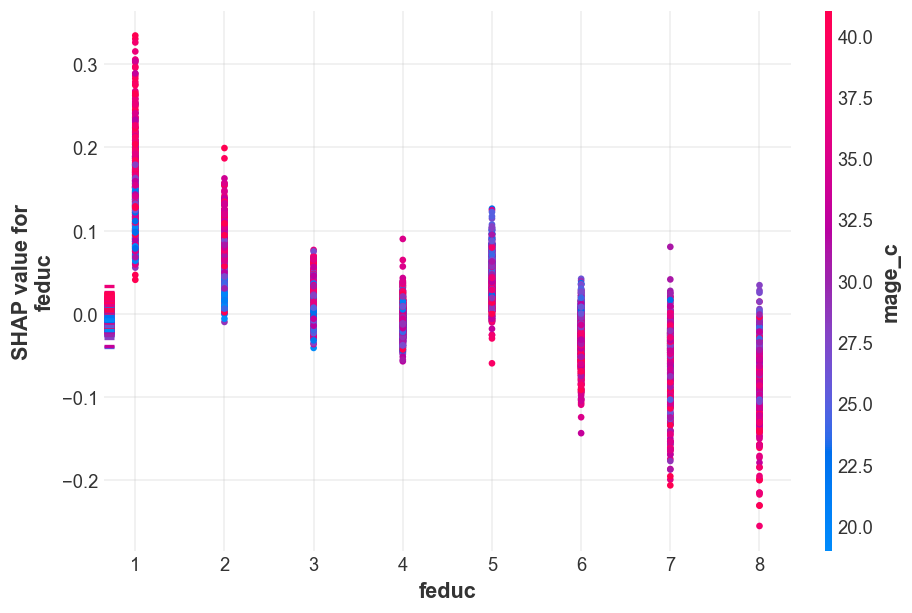


Feature: mrace6


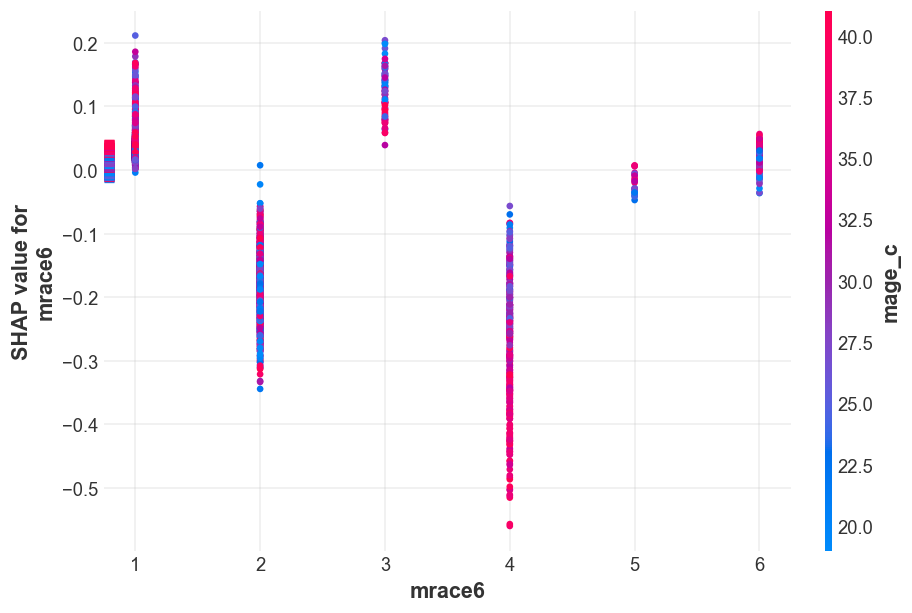


Feature: frace6


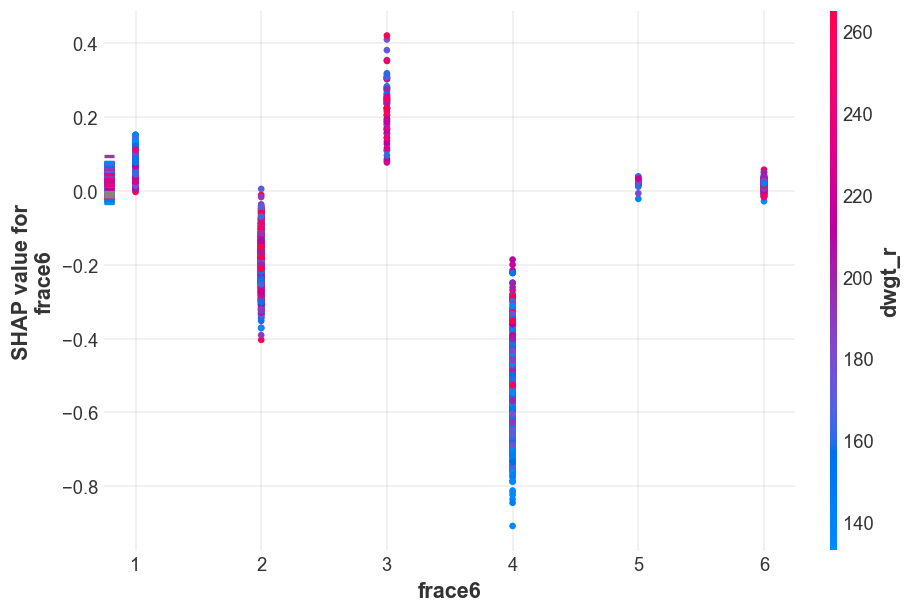


Feature: mhisp_r


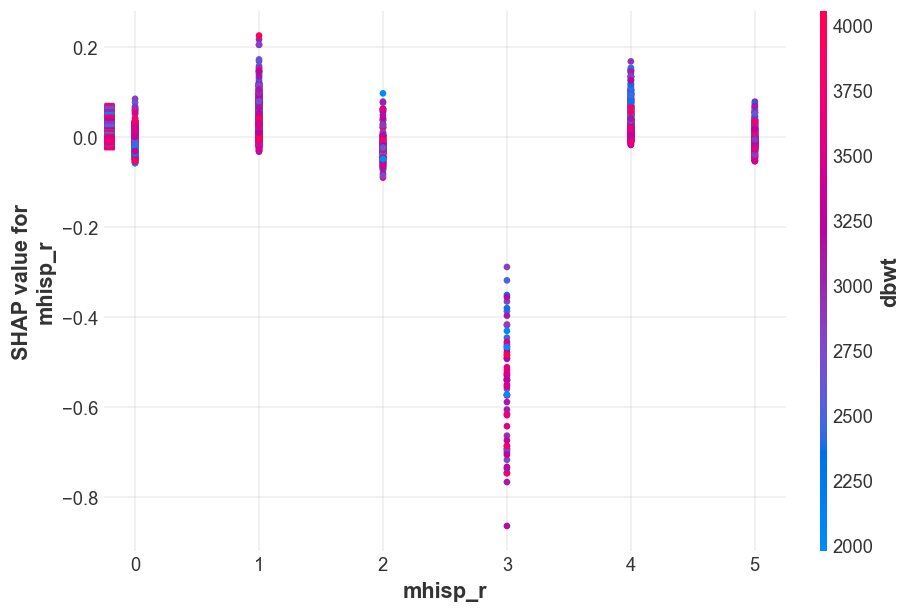


Feature: fhisp_r


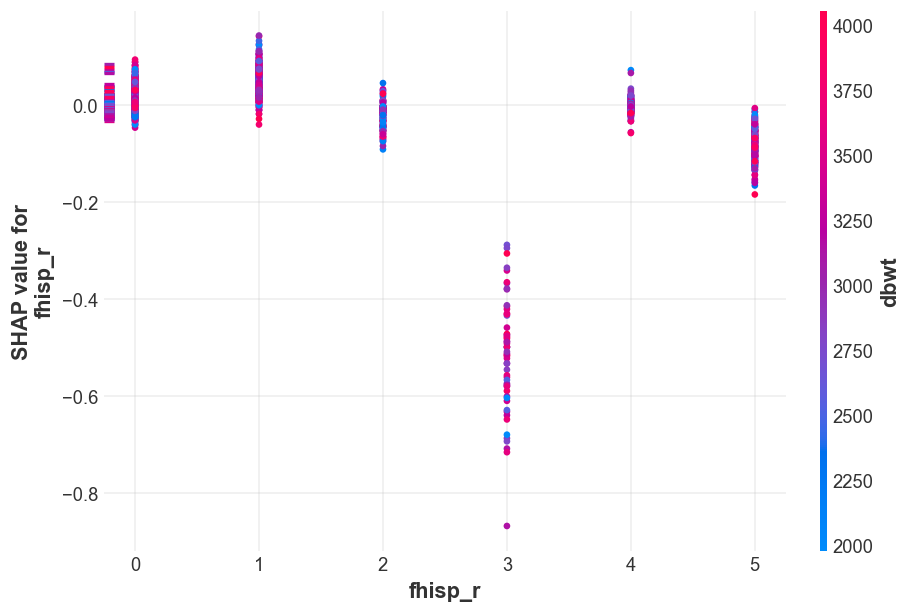


Feature: pay_rec


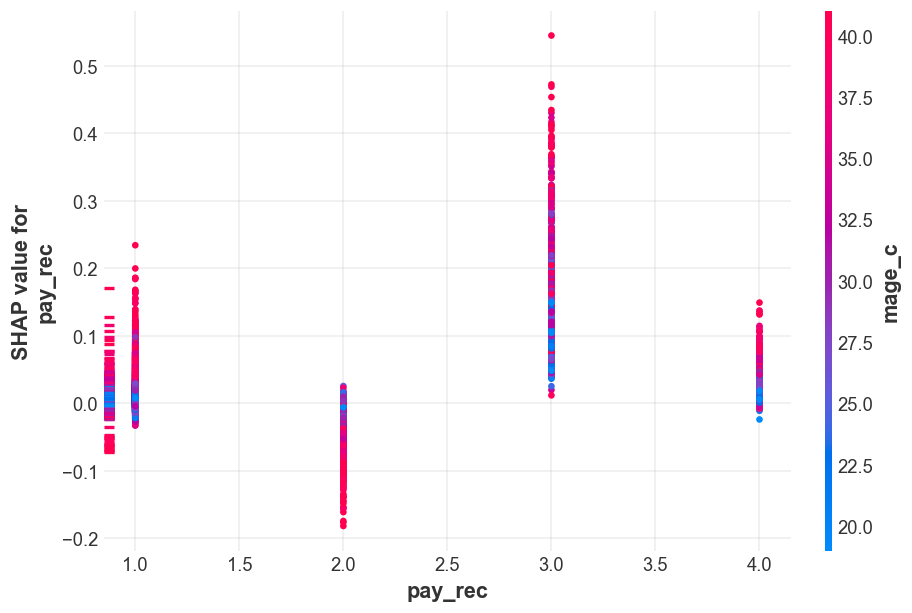


Feature: wic


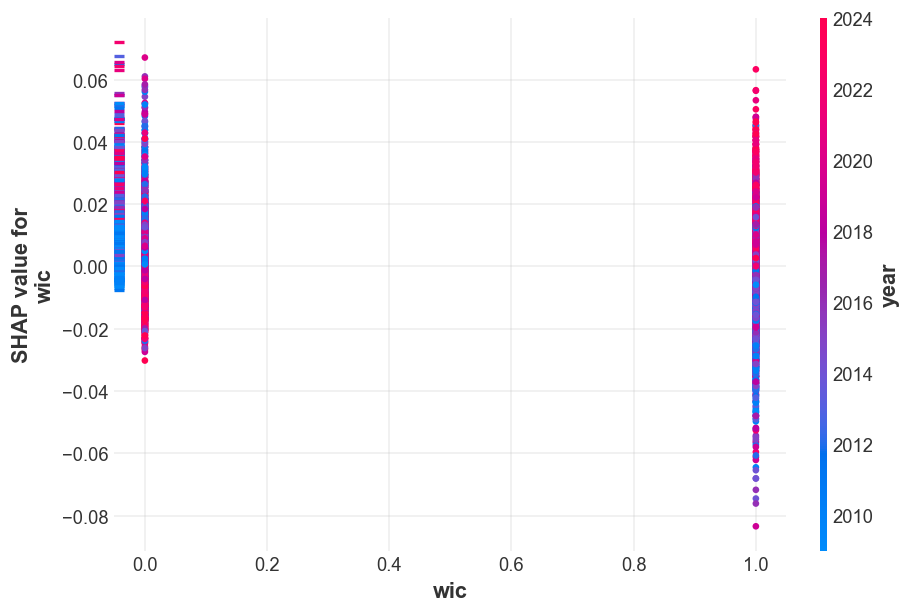

In [30]:
X_shap_fp = X_shap.astype("float32")
for name in X_shap_fp.columns:
    print(f"\nFeature: {name}")
    shap.dependence_plot(name, shap_values, X_shap_fp)

In [82]:
by_year = df.groupby("year", dropna=True).mean(numeric_only=True).reset_index().sort_values("year")
by_year

year  ca_down_c_or_p     mage_c   fagecomb  fagerec11      pwgt_r  \
0   2009        0.000334  27.511429  30.508335   4.698407  152.918003   
1   2010        0.000378  27.685057   30.68469   4.730457  153.774955   
2   2011        0.000417  27.853222  30.837912   4.753775  154.261506   
3   2012        0.000439  27.984079  30.964278    4.77439  154.537869   
4   2013        0.000470  28.162348  31.091211   4.801059  155.185884   
5   2014        0.000482  28.351311  31.197885   4.830784  155.664678   
6   2015        0.000511  28.513949  31.360821   4.858113  156.379667   
7   2016        0.000548  28.709305  31.562571   4.891925  157.042768   
8   2017        0.000529  28.846844  31.682617   4.914152  157.987593   
9   2018        0.000555  29.009016  31.801564   4.936516  159.092729   
10  2019        0.000540  29.113574  31.862218   4.947411  159.956398   
11  2020        0.000540  29.224665  31.954835    4.96758  161.073308   
12  2021        0.000519  29.407765  32.011939   4.980669  161.953432   
13  2022        0.000506  29.515258  32.085151   4.994085  162.432619   
14  2023        0.000515  29.581470   32.11166   4.997545   162.74564   
15  2024        0.000518  29.670694  32.131809   5.001225  162.823095   

        dwgt_r     wtgain  wtgain_rec  rf_ppterm  ...        bmi     bmi_r  \
0    183.50258  30.541775    3.345267   0.019581  ...  26.093252  2.792287   
1   184.179617  30.398755    3.338459   0.021154  ...  26.214628  2.812953   
2   184.636817  30.447513    3.345449   0.022396  ...  26.284519  2.824321   
3    184.77844  30.347376    3.337278   0.024035  ...  26.341291  2.834487   
4   185.383212  30.333064    3.337136   0.025964  ...  26.456406  2.854429   
5   185.861875  30.379733    3.341644   0.027741  ...  26.542339  2.869157   
6   186.295239  30.102135    3.317971   0.029357  ...  26.681412  2.893593   
7   186.761266  29.928282    3.302848   0.030914  ...  26.802498   2.91448   
8   187.367867  29.606339    3.276019   0.032798  ...  26.973864  2.944252   
9    188.32216  29.473303    3.264651   0.035323  ...  27.167784  2.978712   
10   189.15823  29.446917    3.261485   0.036389  ...  27.334270  3.008046   
11  190.334742  29.495376    3.261291   0.036956  ...  27.530973  3.042493   
12  191.254847   29.54973    3.262067   0.037981  ...  27.670580  3.067334   
13  191.060962  28.926404    3.209713   0.038834  ...  27.792480  3.089407   
14  191.665824  29.206489    3.229624   0.039595  ...  27.866743  3.102935   
15   191.97234  29.434767    3.243687   0.039953  ...  27.903193  3.108034   

       meduc     feduc    mrace6    frace6   mhisp_r   fhisp_r   pay_rec  \
0   3.934805  3.931729      <NA>      <NA>      <NA>      <NA>  1.715414   
1     4.0233  4.012842      <NA>      <NA>      <NA>      <NA>  1.698949   
2   4.104408  4.078964      <NA>      <NA>      <NA>      <NA>  1.702957   
3   4.159243  4.121247      <NA>      <NA>      <NA>      <NA>  1.709946   
4   4.203357  4.151211      <NA>      <NA>      <NA>      <NA>   1.70617   
5   4.231763  4.173194      <NA>  1.475968  0.506275  0.498822  1.694511   
6   4.263361  4.188862      <NA>  1.480919  0.517416  0.511487  1.696109   
7   4.306369  4.224561      <NA>  1.497489  0.524643  0.516528  1.696213   
8   4.323927   4.23306      <NA>   1.50876  0.534606  0.527313  1.690158   
9   4.352515  4.253657   1.52277  1.510465   0.54338  0.538058  1.698693   
10  4.369933  4.259226  1.529591  1.519056  0.545097  0.529898  1.693936   
11  4.387365  4.282142  1.527842  1.513849  0.555373  0.537242  1.690422   
12  4.450029  4.313404  1.518427  1.506922  0.565591  0.545542   1.69955   
13  4.445927  4.297375  1.525353  1.515539  0.600309  0.579237  1.697883   
14  4.447478  4.292072   1.52749  1.521261  0.625627  0.602949  1.695934   
15  4.459342  4.299851  1.533267  1.529715  0.652737  0.627535  1.714318   

         wic  
0   0.482634  
1     0.4795  
2   0.471871  
3   0.466522  
4   0.451265  
5   0.434936  
6   0.416129  
7   0.395457  
8   0.3